# Interpretation of Deep-learning Models for Predicting Thunderstorm Rotation

Please cite this notebook as follows.

Lagerquist, R., and D.J. Gagne II, 2019: "Interpretation of deep-learning models for predicting thunderstorm rotation: Python tutorial". https://github.com/djgagne/ams-ml-python-course/blob/ryan_branch/module_4/ML_Short_Course_Module_4_Interpretation.ipynb.

The first use of this notebook was for a short course ([Machine Learning in Python for Environmental Science Problems](https://annual.ametsoc.org/index.cfm/2019/programs/short-courses-workshops/machine-learning-in-python-for-environmental-science-problems/)) at the American Meteorological Society's (AMS) 2019 annual meeting.

# References

This notebook refers to a few publications, listed below.

Breiman, L., 2001: "Random forests." *Machine Learning*, **45**, 5–32, https://doi.org/10.1023/A:1010933404324.

Hsu, W., and A. Murphy, 1986: "The attributes diagram: A geometrical framework for assessing the quality of probability forecasts." *International Journal of Forecasting*, **2**, 285–293, https://doi.org/10.1016/0169-2070(86)90048-8.

Lakshmanan, V., C. Karstens, J. Krause, K. Elmore, A. Ryzhkov, and S. Berkseth, 2015: "Which polarimetric variables are important for weather/no-weather discrimination?" *Journal of Atmospheric and Oceanic Technology*, **32**, 1209-1223, https://doi.org/10.1175/JTECH-D-13-00205.1.

Metz, C., 1978: "Basic principles of ROC analysis." *Seminars in Nuclear Medicine*, **8**, 283–298, https://doi.org/10.1016/S0001-2998(78)80014-2.

Olah, C., A. Mordvintsev, and L. Schubert, 2017: "Feature visualization." *Distill*, https://doi.org/10.23915/distill.00007.

Roebber, P., 2009: "Visualizing multiple measures of forecast quality." *Weather and Forecasting*, **24**, 601-608, https://doi.org/10.1175/2008WAF2222159.1.

Simonyan, K., A. Vedaldi, and A. Zisserman, 2014: "Deep inside convolutional networks: Visualising image classification models and saliency maps." *arXiv e-prints*, **1312**, https://arxiv.org/abs/1312.6034.

Wagstaff, K., and J. Lee: "Interpretable discovery in large image data sets." *arXiv e-prints*, **1806**, https://arxiv.org/abs/1806.08340.

# Setup

To use this notebook, you will need Python 3.6 and the following packages.

 - scipy
 - TensorFlow
 - Keras
 - scikit-image
 - netCDF4
 - pyproj
 - scikit-learn
 - opencv-python
 - matplotlib
 - shapely
 - geopy
 - metpy
 - descartes

If you have Anaconda on a Linux or Mac, you can install these packages with the commands `pip install scipy`, `pip install tensorflow`, etc.

# Imports

The next cell imports all libraries that will be used by this notebook.  If the notebook crashes anywhere, it will probably be here.

In [1]:
%matplotlib inline
import os.path
import numpy
import keras
from matplotlib import pyplot
from interpretation import utils, normalization, binarization
from interpretation import plotting
from interpretation import cnn, permutation, saliency, class_activation
from interpretation import backwards_optimization as backwards_opt

/home/ryan.lagerquist/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/home/ryan.lagerquist/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/ryan.lagerquist/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/ryan.lagerquis

# Prevent Auto-scrolling

The next cell prevents output in the notebook from being nested in a scroll box (the scroll box is small and makes things hard to see).

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

# Constants

In [3]:
IMAGE_DIR_NAME = '../data/track_data_ncar_ams_3km_nc_small'

BEST_HIT_MATRIX_KEY = 'best_hits_predictor_matrix'
WORST_FALSE_ALARM_MATRIX_KEY = 'worst_false_alarms_predictor_matrix'
WORST_MISS_MATRIX_KEY = 'worst_misses_predictor_matrix'
BEST_CORRECT_NULLS_MATRIX_KEY = 'best_correct_nulls_predictor_matrix'
PREDICTOR_NAMES_KEY = 'predictor_names'

SEPARATOR_STRING = '\n\n' + '*' * 50 + '\n\n'
MINOR_SEPARATOR_STRING = '\n\n' + '-' * 50 + '\n\n'

# Image Files: Example 1

The next cell finds and reads images for all storm objects in July 2015.

In [4]:
image_file_names = utils.find_many_image_files(
    first_date_string='20150701', last_date_string='20150731',
    image_dir_name=IMAGE_DIR_NAME
)

image_dict = utils.read_many_image_files(image_file_names)
print(MINOR_SEPARATOR_STRING)

print('Variables in dictionary are as follows:')
for this_key in image_dict.keys():
    print(this_key)

print('\nPredictor variables are as follows:')
predictor_names = image_dict[utils.PREDICTOR_NAMES_KEY]
for this_name in predictor_names:
    print(this_name)

these_predictor_values = (
    image_dict[utils.PREDICTOR_MATRIX_KEY][0, :5, :5, 0]
)
print('\nSome values of "{0:s}" for first storm object:\n{1:s}'.format(
    predictor_names[0], str(these_predictor_values)
))

these_target_values = image_dict[utils.TARGET_MATRIX_KEY][0, :5, :5]
print('\nSome values of "{0:s}" for first storm object:\n{1:s}'.format(
    image_dict[utils.TARGET_NAME_KEY], str(these_predictor_values)
))

Reading data from: "../data/track_data_ncar_ams_3km_nc_small/NCARSTORM_20150706-0000_d01_model_patches.nc"...
Reading data from: "../data/track_data_ncar_ams_3km_nc_small/NCARSTORM_20150712-0000_d01_model_patches.nc"...


--------------------------------------------------


Variables in dictionary are as follows:
storm_ids
storm_steps
predictor_names
predictor_matrix
target_name
target_matrix

Predictor variables are as follows:
reflectivity_dbz
temperature_kelvins
u_wind_m_s01
v_wind_m_s01

Some values of "reflectivity_dbz" for first storm object:
[[13.97686386 19.82977104 19.72230339 12.15658951 24.21878624]
 [11.72174263 16.28964233 17.1885643   8.1463623  21.16093636]
 [ 8.37331963 13.1016016  13.51956081  4.92564344 15.90840054]
 [ 1.74170113 11.59834766  7.84896898  0.69869119  4.64704037]
 [ 6.33569193  7.28762817  7.5872879   8.06334972 10.47385979]]

Some values of "max_future_vorticity_s01" for first storm object:
[[13.97686386 19.82977104 19.72230339 12.15658951 24.21878624]

# Training and Validation Files

The next cell finds training (2010-2014) and validation (2015) files for deep learning.

In [5]:
training_file_names = utils.find_many_image_files(
    first_date_string='20100101', last_date_string='20141224',
    image_dir_name=IMAGE_DIR_NAME
)

validation_file_names = utils.find_many_image_files(
    first_date_string='20150101', last_date_string='20151231',
    image_dir_name=IMAGE_DIR_NAME
)

validation_image_dict = utils.read_many_image_files(validation_file_names)

Reading data from: "../data/track_data_ncar_ams_3km_nc_small/NCARSTORM_20150331-0000_d01_model_patches.nc"...
Reading data from: "../data/track_data_ncar_ams_3km_nc_small/NCARSTORM_20150416-0000_d01_model_patches.nc"...
Reading data from: "../data/track_data_ncar_ams_3km_nc_small/NCARSTORM_20150422-0000_d01_model_patches.nc"...
Reading data from: "../data/track_data_ncar_ams_3km_nc_small/NCARSTORM_20150505-0000_d01_model_patches.nc"...
Reading data from: "../data/track_data_ncar_ams_3km_nc_small/NCARSTORM_20150510-0000_d01_model_patches.nc"...
Reading data from: "../data/track_data_ncar_ams_3km_nc_small/NCARSTORM_20150523-0000_d01_model_patches.nc"...
Reading data from: "../data/track_data_ncar_ams_3km_nc_small/NCARSTORM_20150528-0000_d01_model_patches.nc"...
Reading data from: "../data/track_data_ncar_ams_3km_nc_small/NCARSTORM_20150605-0000_d01_model_patches.nc"...
Reading data from: "../data/track_data_ncar_ams_3km_nc_small/NCARSTORM_20150612-0000_d01_model_patches.nc"...
Reading da

# Plotting Predictors: Example 1

The next cell plots all predictors for the first validation example.

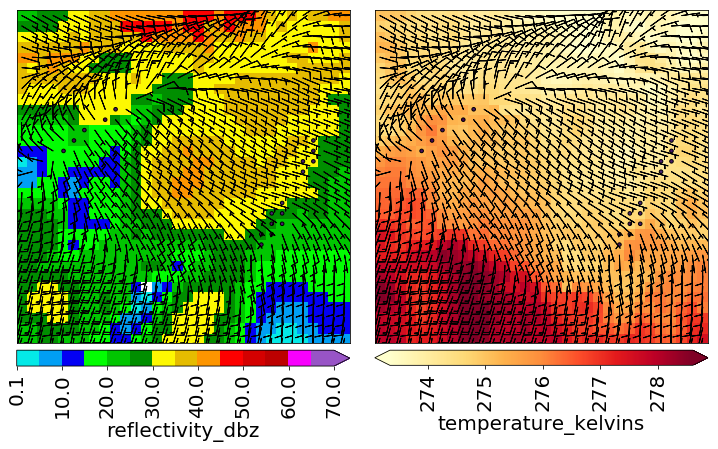

In [6]:
predictor_matrix = validation_image_dict[utils.PREDICTOR_MATRIX_KEY][0, ...]
predictor_names = validation_image_dict[utils.PREDICTOR_NAMES_KEY]

temperature_matrix_kelvins = predictor_matrix[
    ..., predictor_names.index(utils.TEMPERATURE_NAME)
]
min_temp_kelvins = numpy.percentile(temperature_matrix_kelvins, 1)
max_temp_kelvins = numpy.percentile(temperature_matrix_kelvins, 99)

plotting.plot_many_predictors_with_barbs(
    predictor_matrix=predictor_matrix, predictor_names=predictor_names,
    min_colour_temp_kelvins=min_temp_kelvins,
    max_colour_temp_kelvins=max_temp_kelvins
)

pyplot.show()

# Plotting Predictors: Example 2

The next cell plots all predictors for the validation example with the greatest future vorticity.

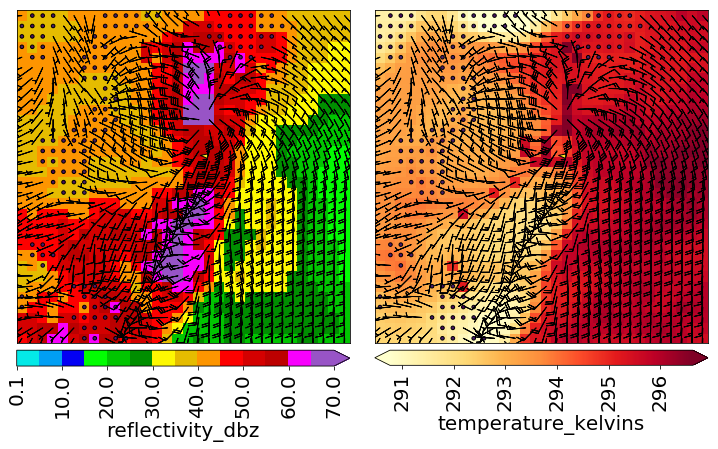

In [7]:
target_matrix_s01 = validation_image_dict[utils.TARGET_MATRIX_KEY]
example_index = numpy.unravel_index(
    numpy.argmax(target_matrix_s01), target_matrix_s01.shape
)[0]

predictor_matrix = validation_image_dict[utils.PREDICTOR_MATRIX_KEY][
    example_index, ...
]
predictor_names = validation_image_dict[utils.PREDICTOR_NAMES_KEY]

temperature_matrix_kelvins = predictor_matrix[
    ..., predictor_names.index(utils.TEMPERATURE_NAME)
]
min_temp_kelvins = numpy.percentile(temperature_matrix_kelvins, 1)
max_temp_kelvins = numpy.percentile(temperature_matrix_kelvins, 99)

plotting.plot_many_predictors_with_barbs(
    predictor_matrix=predictor_matrix, predictor_names=predictor_names,
    min_colour_temp_kelvins=min_temp_kelvins,
    max_colour_temp_kelvins=max_temp_kelvins
)

pyplot.show()

# Plotting Predictors: Example 3

The next cell plots all predictors for the validation example with the greatest future vorticity.

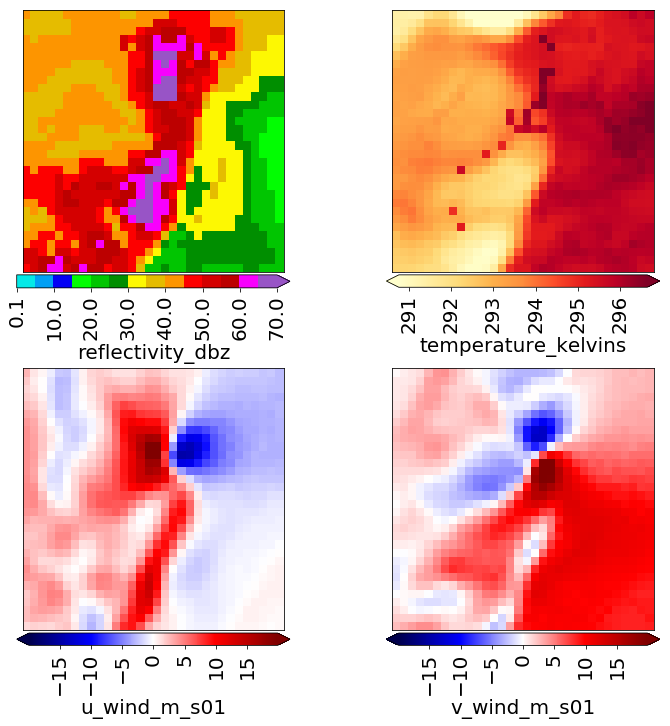

In [8]:
target_matrix_s01 = validation_image_dict[utils.TARGET_MATRIX_KEY]
example_index = numpy.unravel_index(
    numpy.argmax(target_matrix_s01), target_matrix_s01.shape
)[0]

predictor_matrix = validation_image_dict[utils.PREDICTOR_MATRIX_KEY][
    example_index, ...
]
predictor_names = validation_image_dict[utils.PREDICTOR_NAMES_KEY]

temperature_matrix_kelvins = predictor_matrix[
    ..., predictor_names.index(utils.TEMPERATURE_NAME)
]
min_temp_kelvins = numpy.percentile(temperature_matrix_kelvins, 1)
max_temp_kelvins = numpy.percentile(temperature_matrix_kelvins, 99)

wind_speed_matrix_m_s01 = numpy.sqrt(
    predictor_matrix[..., predictor_names.index(utils.U_WIND_NAME)] ** 2 +
    predictor_matrix[..., predictor_names.index(utils.V_WIND_NAME)] ** 2
)
max_speed_m_s01 = numpy.percentile(
    numpy.absolute(wind_speed_matrix_m_s01), 99
)

plotting.plot_many_predictors_sans_barbs(
    predictor_matrix=predictor_matrix, predictor_names=predictor_names,
    min_colour_temp_kelvins=min_temp_kelvins,
    max_colour_temp_kelvins=max_temp_kelvins,
    max_colour_wind_speed_m_s01=max_speed_m_s01
)

pyplot.show()

# Normalization Parameters: Example

The next cell computes the normalization parameters that will be used throughout this notebook.  Normalization parameters should be computed only on the training data, and the same parameters should be used to normalize any other data (*e.g.*, validation data, testing data, or future data in an operational forecasting application).

In [9]:
normalization_dict = normalization.get_image_normalization_params(
    training_file_names
)

Reading data from: "../data/track_data_ncar_ams_3km_nc_small/NCARSTORM_20101024-0000_d01_model_patches.nc"...
Reading data from: "../data/track_data_ncar_ams_3km_nc_small/NCARSTORM_20101122-0000_d01_model_patches.nc"...
Reading data from: "../data/track_data_ncar_ams_3km_nc_small/NCARSTORM_20110201-0000_d01_model_patches.nc"...
Reading data from: "../data/track_data_ncar_ams_3km_nc_small/NCARSTORM_20110308-0000_d01_model_patches.nc"...
Reading data from: "../data/track_data_ncar_ams_3km_nc_small/NCARSTORM_20110326-0000_d01_model_patches.nc"...
Reading data from: "../data/track_data_ncar_ams_3km_nc_small/NCARSTORM_20110404-0000_d01_model_patches.nc"...
Reading data from: "../data/track_data_ncar_ams_3km_nc_small/NCARSTORM_20110414-0000_d01_model_patches.nc"...
Reading data from: "../data/track_data_ncar_ams_3km_nc_small/NCARSTORM_20110420-0000_d01_model_patches.nc"...
Reading data from: "../data/track_data_ncar_ams_3km_nc_small/NCARSTORM_20110425-0000_d01_model_patches.nc"...
Reading da

# Normalization and Denormalization: Example

The next cell normalizes and denormalizes images from one file.  The denormalized values should be exactly equal to the original values.

In [10]:
image_dict = utils.read_image_file(training_file_names[0])
predictor_names = image_dict[utils.PREDICTOR_NAMES_KEY]
these_predictor_values = (
    image_dict[utils.PREDICTOR_MATRIX_KEY][0, :5, :5, 0]
)

print('\nOriginal values of "{0:s}" for first storm object:\n{1:s}'.format(
    predictor_names[0], str(these_predictor_values)
))

image_dict[utils.PREDICTOR_MATRIX_KEY], _ = normalization.normalize_images(
    predictor_matrix=image_dict[utils.PREDICTOR_MATRIX_KEY],
    predictor_names=predictor_names,
    normalization_dict=normalization_dict
)

these_predictor_values = (
    image_dict[utils.PREDICTOR_MATRIX_KEY][0, :5, :5, 0]
)
print((
    '\nNormalized values of "{0:s}" for first storm object:\n{1:s}'
).format(
    predictor_names[0], str(these_predictor_values)
))

image_dict[utils.PREDICTOR_MATRIX_KEY] = normalization.denormalize_images(
    predictor_matrix=image_dict[utils.PREDICTOR_MATRIX_KEY],
    predictor_names=predictor_names,
    normalization_dict=normalization_dict
)

these_predictor_values = (
    image_dict[utils.PREDICTOR_MATRIX_KEY][0, :5, :5, 0]
)
print((
    '\nDenormalized values of "{0:s}" for first storm object:\n{1:s}'
).format(
    predictor_names[0], str(these_predictor_values)
))


Original values of "reflectivity_dbz" for first storm object:
[[ 0.          6.9651885   6.99899673  3.64286256  0.        ]
 [ 1.818367    4.22854471  0.28074482  0.          0.        ]
 [ 7.24424314  4.46407127  0.          0.          0.        ]
 [16.65088844 18.46622086 17.29220772 13.19463634  2.80103612]
 [19.96715736 22.98410988 23.0850563  19.88584709 11.70358849]]

Normalized values of "reflectivity_dbz" for first storm object:
[[-1.43928327 -0.99737685 -0.99523189 -1.20816184 -1.43928327]
 [-1.32391697 -1.17100323 -1.42147142 -1.43928327 -1.43928327]
 [-0.97967223 -1.15606025 -1.43928327 -1.43928327 -1.43928327]
 [-0.38286757 -0.2676938  -0.34217907 -0.6021495  -1.26157152]
 [-0.17246687  0.0189437   0.02534824 -0.1776256  -0.69674904]]

Denormalized values of "reflectivity_dbz" for first storm object:
[[ 0.          6.9651885   6.99899673  3.64286256  0.        ]
 [ 1.818367    4.22854471  0.28074482  0.          0.        ]
 [ 7.24424314  4.46407127  0.          0.      

# Binarization Threshold

The next cell defines a method that finds the "binarization threshold," used to simplify the target variable (maximum future vorticity within the same storm).  The original target variable is on a $32 \times 32$ grid, where the value at grid cell $(i, j)$ is max future vorticity within the storm at grid cell $(i, j)$.  One could train a deep-learning model to predict max future vorticity at each grid cell, but this would be a regression task with 1024 output variables, which would make the rest of this notebook too complicated for a 1.5-hour tutorial.

To simplify the prediction task, the binarization threshold ($\zeta^*$) is applied to the max future vorticity over all 1024 grid cells.  If this value is $\ge \zeta^*$, the storm object is labeled a "1" or "yes"; otherwise, the storm object is labeled a "0" or "no".  This turns the prediction task into binary classification with only one output variable.

# Binarization Threshold: Example

The next cell computes the binarizarion threshold that will be used throughout this notebook.  The binarization threshold should be computed only on the training data, and the same threshold should be used to binarize any other data (*e.g.*, validation data, testing data, or future data in an operational forecasting application).

In [11]:
binarization_threshold = binarization.get_binarization_threshold(
    image_file_names=training_file_names, percentile_level=90.
)

Reading data from: "../data/track_data_ncar_ams_3km_nc_small/NCARSTORM_20101024-0000_d01_model_patches.nc"...
Reading data from: "../data/track_data_ncar_ams_3km_nc_small/NCARSTORM_20101122-0000_d01_model_patches.nc"...
Reading data from: "../data/track_data_ncar_ams_3km_nc_small/NCARSTORM_20110201-0000_d01_model_patches.nc"...
Reading data from: "../data/track_data_ncar_ams_3km_nc_small/NCARSTORM_20110308-0000_d01_model_patches.nc"...
Reading data from: "../data/track_data_ncar_ams_3km_nc_small/NCARSTORM_20110326-0000_d01_model_patches.nc"...
Reading data from: "../data/track_data_ncar_ams_3km_nc_small/NCARSTORM_20110404-0000_d01_model_patches.nc"...
Reading data from: "../data/track_data_ncar_ams_3km_nc_small/NCARSTORM_20110414-0000_d01_model_patches.nc"...
Reading data from: "../data/track_data_ncar_ams_3km_nc_small/NCARSTORM_20110420-0000_d01_model_patches.nc"...
Reading data from: "../data/track_data_ncar_ams_3km_nc_small/NCARSTORM_20110425-0000_d01_model_patches.nc"...
Reading da

# Binarization: Example

The next cell binarizes images from one file.

In [12]:
image_dict = utils.read_image_file(training_file_names[0])
target_matrix_s_01 = image_dict[utils.TARGET_MATRIX_KEY]
numpy.random.shuffle(target_matrix_s_01)

max_target_values_s01 = numpy.max(target_matrix_s_01, axis=(1, 2))
print((
    '\nSpatial maxima of "{0:s}" for the first few storm objects:\n{1:s}'
).format(
    image_dict[utils.TARGET_NAME_KEY], str(max_target_values_s01[:20])
))

target_values = binarization.binarize_target_images(
    target_matrix=image_dict[utils.TARGET_MATRIX_KEY],
    binarization_threshold=binarization_threshold
)

print((
    '\nBinarized target values for the first few storm objects:\n{0:s}'
).format(
    str(target_values[:20])
))


Spatial maxima of "max_future_vorticity_s01" for the first few storm objects:
[0.00262358 0.01239421 0.00110068 0.00222461 0.00162088 0.00223799
 0.00178306 0.00167922 0.00114118 0.00263275 0.00211066 0.00154246
 0.00784997 0.00148898 0.00206304 0.00190724 0.00078791 0.00293642
 0.00236613 0.00140724]

Binarized target values for the first few storm objects:
[0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]


# CNN Setup

The next cell defines methods for setting up (but not training) a CNN.  "Setting up" means defining the architecture, loss function, and optimizer.  The loss function for classification is almost always cross-entropy, and one of the preferred optimizers in the deep-learning community is Adam, so these are both defaults in the method `setup_cnn`.  The architecture used in `setup_cnn` is much more heuristic &ndash; it is based on my intuition and architectures that have worked for me in similar problems (*e.g.*, front detection where the inputs were $33 \times 33$ grids of temperature, specific humidity, $u$-wind, and $v$-wind).  There is almost undoubtedly a better architecture, so feel free to experiment.

In [13]:
def _get_dense_layer_dimensions(num_input_neurons, num_classes,
                                num_dense_layers):
    """Returns dimensions (num input and output neurons) for each dense layer.

    D = number of dense layers

    :param num_input_neurons: Number of input neurons (features created by
        flattening layer).
    :param num_classes: Number of output classes (possible values of target
        variable).
    :param num_dense_layers: Number of dense layers.
    :return: num_inputs_by_layer: length-D numpy array with number of input
        neurons by dense layer.
    :return: num_outputs_by_layer: length-D numpy array with number of output
        neurons by dense layer.
    """

    if num_classes == 2:
        num_output_neurons = 1
    else:
        num_output_neurons = num_classes + 0

    e_folding_param = (
        -1.0 * num_dense_layers /
        numpy.log(float(num_output_neurons) / num_input_neurons)
    )

    dense_layer_indices = numpy.linspace(
        0, num_dense_layers - 1, num=num_dense_layers, dtype=float
    )
    num_inputs_by_layer = num_input_neurons * numpy.exp(
        -dense_layer_indices / e_folding_param
    )
    num_inputs_by_layer = numpy.round(num_inputs_by_layer).astype(int)

    num_outputs_by_layer = numpy.concatenate((
        num_inputs_by_layer[1:],
        numpy.array([num_output_neurons], dtype=int)
    ))

    return num_inputs_by_layer, num_outputs_by_layer

# CNN Setup: Example

The next cell runs `setup_cnn`, which prints the architecture in a plain-text table.  The architecture is easier to understand as an image, shown below (created with [this website](http://alexlenail.me/NN-SVG/AlexNet.html)).  This image shows the effects of the convolutional, pooling, and dense layers, on the dimensions of the model grids as they are passed through the CNN.  The image does **not** show the effects of batch normalization or leaky ReLU (the activation function), because these change only the values in the grids, not the grid dimensions.

 - The input data have dimensions of $32 \times 32 \times 4$ (32 spatial rows, 32 spatial columns, and 4 variables: reflectivity, temperature, $u$-wind, and $v$-wind).

 - After one convolution, the data have dimensions of $30 \times 30 \times 32$ (30 rows, 30 columns, and 32 filters).  A "filter" can be thought of as a transformed input variable (the output of a transformation applied to the 4 original variables).  The grids have fewer rows and columns because the convolution window, which is $3 \times 3$, cannot be applied at the edges of the input.  A $3 \times 3$ convolution always removes 2 rows and 2 columns from the grids.  In general, a $J \times K$ convolution always removes $J - 1$ rows and $K - 1$ columns.

 - After the second convolution, the data have dimensions of $28 \times 28 \times 64$ (28 rows, 28 columns, and 64 filters).  In general, as data are passed through the CNN, the spatial dimensions shrink and the number of filters grows.

 - After the first pooling, the data have dimensions of $14 \times 14 \times 64$.  The $2 \times 2$ pooling window cuts the spatial dimensions in half.  In general, a $J \times K$ pooling window cuts the number of rows by a factor of $J$ and number of columns by a factor of $K$.  This CNN uses max-pooling, where each output value in filter $F$ is the maximum input $F$-value inside the pooling window.  You can also use mean-pooling.  Pooling allows deeper layers (to the right) to detect larger-scale features than shallower layers (to the left).  Both small-scale and large-scale features may be important to the prediction task.

 - The next convolution changes the dimensions to $12 \times 12 \times 128$.

 - The next convolution changes the dimensions to $10 \times 10 \times 256$.

 - The next pooling changes the dimensions to $5 \times 5 \times 256$.

 - The 256 images ("feature maps") are flattened into a length-6400 vector.

 - The first dense layer (or "fully connected" layer; this is the same as a hidden layer in a traditional neural net) transforms the 6400 scalar features into 345 scalar features.

 - The next dense layer transforms 345 scalar features into 19 scalar features.

 - The final dense layer transforms 19 scalar features into one value (probability of class = 1, or probability that the storm's maximum future vorticity is $\ge \zeta^*$, the binarization threshold).  This layer uses the sigmoid activation function, which has an output range of $\left[0, 1\right]$, which allows the output to be interpreted as a probability.  For each **batch** of training examples, these probabilities are compared with the true labels (either 0 or 1) and the cross-entropy is computed.  Cross-entropy is defined as follows.

$\epsilon = -\frac{1}{N} \left[ y_i\textrm{ log}_2(\hat{y}_i) + (1 - y_i)\textrm{ log}_2(1 - \hat{y}_i) \right]$

$N$ is the number of examples in the batch; $y_i$ is the true label (0 or 1) for the $i^{\textrm{th}}$ example; and $\hat{y}_i$ is the predicted probability of class = 1 for the $i^{\textrm{th}}$ example.  $\epsilon$ is the resulting cross-entropy.  Cross-entropy is negatively oriented (lower is better), and a value of zero is perfect.

Once the cross-entropy has been computed, all weights in the CNN &ndash; most of which reside in the convolutional and dense layers &ndash; are adjusted slightly in a way that reduces cross-entropy.  For each weight $w$, this is found by computing the gradient $\frac{\partial \epsilon}{\partial w}$ and incrementing $w$ by $-\alpha \frac{\partial \epsilon}{\partial w}$, where $\alpha$ is a small positive number.

<img src="cnn_architecture.jpg" alt="CNN architecture" width="1000" />

In [13]:
NUM_CONV_LAYER_SETS = 2
NUM_CONV_LAYERS_PER_SET = 2
FIRST_NUM_CONV_FILTERS = 32
NUM_CONV_FILTER_ROWS = 3
NUM_CONV_FILTER_COLUMNS = 3

L1_WEIGHT = 0.
L2_WEIGHT = 0.001
SLOPE_FOR_RELU = 0.2
NUM_DENSE_LAYERS = 3
DENSE_LAYER_DROPOUT_FRACTION = 0.5

regularizer_object = keras.regularizers.l1_l2(l1=L1_WEIGHT, l2=L2_WEIGHT)

# Find grid dimensions and number of channels.
image_dict = utils.read_image_file(training_file_names[0])
predictor_matrix = image_dict[utils.PREDICTOR_MATRIX_KEY]
num_grid_rows = predictor_matrix.shape[1]
num_grid_columns = predictor_matrix.shape[2]
num_channels = predictor_matrix.shape[3]

# Create input layer.
input_layer_object = keras.layers.Input(
    shape=(num_grid_rows, num_grid_columns, num_channels)
)

# Add convolutional and pooling layers, with activation and batch
# normalization after each conv layer.
current_num_filters = None
current_layer_object = None

for _ in range(NUM_CONV_LAYER_SETS):
    for _ in range(NUM_CONV_LAYERS_PER_SET):
        if current_num_filters is None:
            current_num_filters = FIRST_NUM_CONV_FILTERS + 0
            current_layer_object = input_layer_object
        else:
            current_num_filters *= 2

        current_layer_object = keras.layers.Conv2D(
            filters=current_num_filters,
            kernel_size=(NUM_CONV_FILTER_ROWS, NUM_CONV_FILTER_COLUMNS),
            strides=(1, 1), padding='valid', data_format='channels_last',
            dilation_rate=(1, 1), activation=None, use_bias=True,
            kernel_initializer='glorot_uniform', bias_initializer='zeros',
            kernel_regularizer=regularizer_object
        )(current_layer_object)

        current_layer_object = keras.layers.LeakyReLU(
            alpha=SLOPE_FOR_RELU
        )(current_layer_object)

        current_layer_object = keras.layers.BatchNormalization(
            axis=-1, center=True, scale=True
        )(current_layer_object)

    current_layer_object = keras.layers.MaxPooling2D(
        pool_size=(2, 2), strides=(2, 2),
        padding='valid', data_format='channels_last'
    )(current_layer_object)

these_dimensions = numpy.array(
    current_layer_object.get_shape().as_list()[1:], dtype=int
)
num_scalar_features = numpy.prod(these_dimensions)

current_layer_object = keras.layers.Flatten()(current_layer_object)

# Add non-final dense layers.
_, num_outputs_by_dense_layer = _get_dense_layer_dimensions(
    num_input_neurons=num_scalar_features, num_classes=2,
    num_dense_layers=NUM_DENSE_LAYERS
)

for k in range(NUM_DENSE_LAYERS - 1):
    current_layer_object = keras.layers.Dense(
        num_outputs_by_dense_layer[k], activation=None, use_bias=True,
        kernel_initializer='glorot_uniform', bias_initializer='zeros'
    )(current_layer_object)

    current_layer_object = keras.layers.LeakyReLU(
        alpha=SLOPE_FOR_RELU
    )(current_layer_object)

    current_layer_object = keras.layers.Dropout(
        rate=DENSE_LAYER_DROPOUT_FRACTION
    )(current_layer_object)

    current_layer_object = keras.layers.BatchNormalization(
        axis=-1, center=True, scale=True
    )(current_layer_object)

# Add final dense layer (output layer).
current_layer_object = keras.layers.Dense(
    1, activation=None, use_bias=True,
    kernel_initializer='glorot_uniform', bias_initializer='zeros',
)(current_layer_object)

current_layer_object = keras.layers.Activation(
    'sigmoid'
)(current_layer_object)

if NUM_DENSE_LAYERS == 1:
    current_layer_object = keras.layers.Dropout(
        rate=DENSE_LAYER_DROPOUT_FRACTION
    )(current_layer_object)

# Compile model.
cnn_model_object = keras.models.Model(
    inputs=input_layer_object, outputs=current_layer_object
)
cnn_model_object.compile(
    loss=keras.losses.binary_crossentropy,
    optimizer=keras.optimizers.Adam(),
    metrics=cnn.LIST_OF_METRIC_FUNCTIONS
)
cnn_model_object.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 4)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 30, 30, 32)        1184      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 30, 30, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 30, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
leaky_re_lu_2 (LeakyR

# Training the CNN

The next cell defines a method to train the CNN.

 - `model_object` is the untrained model created by `setup_cnn`.
 - `num_examples_per_batch`, `num_epochs`, and `num_training_batches_per_epoch` determine how many examples are used to train the model.
 - `output_model_file_name` determines where the model will be saved.
 - `validation_file_names` specifies the validation data, which are used during training to monitor the model's performance on a separate dataset.  On-the-fly validation can be used to diagnose overfitting (*e.g.*, if the training loss is decreasing while validation loss increases).  On-the-fly validation can also be used to lower the learning rate, stop training early, etc. &ndash; but these advanced uses, which are beyond the scope of this notebook.

In [14]:
def train_cnn(
        model_object, training_file_names, validation_file_names,
        num_examples_per_batch, normalization_dict, binarization_threshold,
        num_epochs, num_training_batches_per_epoch,
        num_validation_batches_per_epoch, output_file_name):
    """Trains CNN.

    :param model_object: Untrained model (instance of `keras.models.Model` or
        `keras.models.Sequential`).
    :param training_file_names: 1-D list of paths to training files (readable by
        `utils.read_image_file`).
    :param validation_file_names: Same but for validation files.
    :param num_examples_per_batch: See doc for `data_generator`.
    :param normalization_dict: Same.
    :param binarization_threshold: Same.
    :param num_epochs: Number of epochs.
    :param num_training_batches_per_epoch: Number of training batches per epoch.
    :param num_validation_batches_per_epoch: Number of validation batches per
        epoch.
    :param output_file_name: Path to output file.  The trained model will be
        saved here, after each epoch, as an HDF5 file.
    :return: cnn_metadata_dict: See doc for `write_metadata`.
    """

    utils.create_directory(file_name=output_file_name)

    cnn_metadata_dict = {
        cnn.TRAINING_FILES_KEY: training_file_names,
        cnn.NORMALIZATION_DICT_KEY: normalization_dict,
        cnn.BINARIZATION_THRESHOLD_KEY: binarization_threshold,
        cnn.NUM_EXAMPLES_PER_BATCH_KEY: num_examples_per_batch,
        cnn.NUM_TRAINING_BATCHES_KEY: num_training_batches_per_epoch,
        cnn.VALIDATION_FILES_KEY: validation_file_names,
        cnn.NUM_VALIDATION_BATCHES_KEY: num_validation_batches_per_epoch
    }

    checkpoint_object = keras.callbacks.ModelCheckpoint(
        filepath=output_file_name, monitor='val_loss',
        save_best_only=True, save_weights_only=False, mode='min', period=1,
        verbose=1
    )
    early_stopping_object = keras.callbacks.EarlyStopping(
        monitor='val_loss', min_delta=cnn.CROSS_ENTROPY_PATIENCE,
        patience=cnn.EARLY_STOPPING_PATIENCE_EPOCHS, mode='min', verbose=1
    )
    plateau_object = keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss', factor=cnn.PLATEAU_LEARNING_RATE_MULTIPLIER,
        patience=cnn.PLATEAU_PATIENCE_EPOCHS, mode='min',
        min_delta=cnn.CROSS_ENTROPY_PATIENCE,
        cooldown=cnn.PLATEAU_COOLDOWN_EPOCHS,
        verbose=1
    )

    list_of_callback_objects = [
        checkpoint_object, early_stopping_object, plateau_object
    ]

    training_generator = cnn.data_generator(
        image_file_names=training_file_names,
        num_examples_per_batch=num_examples_per_batch,
        normalization_dict=normalization_dict,
        binarization_threshold=binarization_threshold
    )

    validation_generator = cnn.data_generator(
        image_file_names=validation_file_names,
        num_examples_per_batch=num_examples_per_batch,
        normalization_dict=normalization_dict,
        binarization_threshold=binarization_threshold
    )

    model_object.fit_generator(
        generator=training_generator,
        steps_per_epoch=num_training_batches_per_epoch, epochs=num_epochs,
        verbose=1, callbacks=list_of_callback_objects, workers=0,
        validation_data=validation_generator,
        validation_steps=num_validation_batches_per_epoch
    )

    return cnn_metadata_dict

# Training the CNN: Example

The next cell actually trains the CNN.

In [15]:
output_file_name = '{0:s}/custom_cnn/model.h5'.format(IMAGE_DIR_NAME)

# train_cnn(
#     model_object=cnn_model_object,
#     training_file_names=training_file_names,
#     validation_file_names=validation_file_names,
#     normalization_dict=normalization_dict,
#     binarization_threshold=binarization_threshold,
#     num_training_batches_per_epoch=32,
#     num_validation_batches_per_epoch=16,
#     num_examples_per_batch=1024, num_epochs=10,
#     output_file_name=output_file_name
# )

train_cnn(
    model_object=cnn_model_object,
    training_file_names=training_file_names,
    validation_file_names=validation_file_names,
    normalization_dict=normalization_dict,
    binarization_threshold=binarization_threshold,
    num_training_batches_per_epoch=10,
    num_validation_batches_per_epoch=10,
    num_examples_per_batch=256, num_epochs=10,
    output_file_name=output_file_name
)

Instructions for updating:
Use tf.cast instead.
Epoch 1/10
Reading data from: "../data/track_data_ncar_ams_3km_nc_small/NCARSTORM_20120323-0000_d01_model_patches.nc"...
Fraction of examples in positive class: 0.0859
 1/10 [==>...........................] - ETA: 25s - loss: 1.2473 - accuracy: 0.0421 - binary_accuracy: 0.4885 - binary_csi: 0.0761 - binary_frequency_bias: 5.9335 - binary_pod: 0.4904 - binary_pofd: 0.5117 - binary_peirce_score: -0.0213 - binary_success_ratio: 0.0827 - binary_focn: 0.9106Reading data from: "../data/track_data_ncar_ams_3km_nc_small/NCARSTORM_20110420-0000_d01_model_patches.nc"...
Fraction of examples in positive class: 0.0820
 2/10 [=====>........................] - ETA: 15s - loss: 1.2476 - accuracy: 0.0518 - binary_accuracy: 0.5162 - binary_csi: 0.0974 - binary_frequency_bias: 5.9952 - binary_pod: 0.6193 - binary_pofd: 0.4931 - binary_peirce_score: 0.1262 - binary_success_ratio: 0.1031 - binary_focn: 0.9348 Reading data from: "../data/track_data_ncar_ams_3

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/ryan.lagerquist/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2963, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-15-241d46fae347>", line 24, in <module>
    output_file_name=output_file_name
  File "<ipython-input-14-f5f8135a9e09>", line 77, in train_cnn
    validation_steps=num_validation_batches_per_epoch
  File "/home/ryan.lagerquist/anaconda3/lib/python3.6/site-packages/keras/legacy/interfaces.py", line 91, in wrapper
    return func(*args, **kwargs)
  File "/home/ryan.lagerquist/anaconda3/lib/python3.6/site-packages/keras/engine/training.py", line 1418, in fit_generator
    initial_epoch=initial_epoch)
  File "/home/ryan.lagerquist/anaconda3/lib/python3.6/site-packages/keras/engine/training_generator.py", line 217, in fit_generator
    class_weight=class_weight)
  File "/home/ryan.lagerquist/anaconda3/lib/python3.6/site-packages/keras/engine/training.py", li

KeyboardInterrupt: 

# Evaluating the CNN

The next cell defines a method that evaluates the CNN's predictions on new data.  "Evaluation," in this sense, means gauging forecast quality ("how well does the CNN predict maximum future vorticity for a given storm?").  Specifically, `evaluate_cnn` creates a ROC curve (Metz 1978), performance diagram (Roebber 2009), and attributes diagram (Hsu and Murphy 1986).  These are all standard tools for evaluating probabilistic predictions in meteorology.

In [ ]:
def evaluate_cnn(
        cnn_model_object, image_dict, cnn_metadata_dict, output_dir_name):
    """Evaluates trained CNN (convolutional neural net).

    :param cnn_model_object: Trained instance of `keras.models.Model`.
    :param image_dict: Dictionary created by `read_image_file` or
        `read_many_image_files`.  Should contain validation or testing data (not
        training data), but this is not enforced.
    :param cnn_metadata_dict: Dictionary created by `train_cnn`.  This will
        ensure that data in `image_dict` are processed the exact same way as the
        training data for `cnn_model_object`.
    :param output_dir_name: Path to output directory.  Figures will be saved
        here.
    """

    predictor_matrix, _ = normalize_images(
        predictor_matrix=image_dict[PREDICTOR_MATRIX_KEY] + 0.,
        predictor_names=image_dict[PREDICTOR_NAMES_KEY],
        normalization_dict=cnn_metadata_dict[NORMALIZATION_DICT_KEY])
    predictor_matrix = predictor_matrix.astype('float32')

    target_values = binarize_target_images(
        target_matrix=image_dict[TARGET_MATRIX_KEY],
        binarization_threshold=cnn_metadata_dict[BINARIZATION_THRESHOLD_KEY])

    forecast_probabilities = _apply_cnn(cnn_model_object=cnn_model_object,
                                        predictor_matrix=predictor_matrix)
    print(MINOR_SEPARATOR_STRING)

    pofd_by_threshold, pod_by_threshold = roc_curves.plot_roc_curve(
        observed_labels=target_values,
        forecast_probabilities=forecast_probabilities)

    area_under_roc_curve = scikit_learn_auc(pofd_by_threshold, pod_by_threshold)
    title_string = 'Area under ROC curve: {0:.4f}'.format(area_under_roc_curve)

    pyplot.title(title_string)
    pyplot.show()

    _create_directory(directory_name=output_dir_name)
    roc_curve_file_name = '{0:s}/roc_curve.jpg'.format(output_dir_name)

    print('Saving figure to: "{0:s}"...'.format(roc_curve_file_name))
    pyplot.savefig(roc_curve_file_name, dpi=FIGURE_RESOLUTION_DPI)
    pyplot.close()

    performance_diagrams.plot_performance_diagram(
        observed_labels=target_values,
        forecast_probabilities=forecast_probabilities)
    pyplot.show()

    perf_diagram_file_name = '{0:s}/performance_diagram.jpg'.format(
        output_dir_name)

    print('Saving figure to: "{0:s}"...'.format(perf_diagram_file_name))
    pyplot.savefig(perf_diagram_file_name, dpi=FIGURE_RESOLUTION_DPI)
    pyplot.close()

    attributes_diagrams.plot_attributes_diagram(
        observed_labels=target_values,
        forecast_probabilities=forecast_probabilities, num_bins=20)
    pyplot.show()

    attr_diagram_file_name = '{0:s}/attributes_diagram.jpg'.format(
        output_dir_name)

    print('Saving figure to: "{0:s}"...'.format(attr_diagram_file_name))
    pyplot.savefig(attr_diagram_file_name, dpi=FIGURE_RESOLUTION_DPI)
    pyplot.close()

In [20]:
cnn_file_name = './pretrained_cnn/pretrained_cnn.h5'
cnn_metafile_name = cnn.find_model_metafile(model_file_name=cnn_file_name)

cnn_model_object = cnn.read_model(cnn_file_name)
cnn_metadata_dict = cnn.read_metadata(cnn_metafile_name)

# Evaluating the CNN: Example

The next cell reads a pre-trained CNN and runs `evaluate_cnn` on the validation data.

In [16]:
cnn_file_name = '{0:s}/pretrained_cnn/pretrained_cnn.h5'.format(
    MODULE4_DIR_NAME)
cnn_metafile_name = find_model_metafile(model_file_name=cnn_file_name)

cnn_model_object = read_keras_model(cnn_file_name)
cnn_metadata_dict = read_model_metadata(cnn_metafile_name)
validation_dir_name = '{0:s}/validation'.format(MODULE4_DIR_NAME)

# evaluate_cnn(
#     cnn_model_object=cnn_model_object, image_dict=validation_image_dict,
#     cnn_metadata_dict=cnn_metadata_dict,
#     output_dir_name=validation_dir_name)
# print(SEPARATOR_STRING)

NameError: name 'MODULE4_DIR_NAME' is not defined

# Permutation Test

The next cell defines methods that run the permutation test on a trained CNN.  The permutation test is used to gauge the importance of each predictor variable.  There are two versions of the permutation test: single-pass (Breiman 2001) and multi-pass (Lakshmanan *et al.* 2015).

## Breiman Version (figure credit to Amy McGovern)

<img src="breiman_permutation.gif" alt="Breiman permutation" width="500" />

At a given time, only one predictor is permuted (randomized).  The amount by which the cost function increases when $x$ is permuted, is used to gauge the importance of $x$.  If the cost function remains the same or decreases when $x$ is permuted, $x$ is a useless predictor.  If the cost function increases slightly when $x$ is permuted, $x$ is a somewhat important predictor.  If the cost function skyrockets when $x$ is permuted, $x$ is a very important predictor.

## Lakshmanan Version (figure credit to Amy McGovern)

<img src="lak_permutation.gif" alt="Lakshmanan permutation" width="500" />

At a given time, one or more predictors may be permuted (randomized).  The $1^{\textrm{st}}$ predictor permuted is the one that increases the cost function ($\epsilon$) the most with 0 other predictors permuted; the $2^{\textrm{nd}}$ predictor permuted is that which increases $\epsilon$ the most with the $1^{\textrm{st}}$ predictor already permuted; $\ldots$; and the $k^{\textrm{th}}$ predictor permuted is that which increases $\epsilon$ the most with the $1^{\textrm{st}}\ldots(k - 1)^{\textrm{th}}$ predictors already permuted.

# Read Pre-trained CNN

In [14]:
cnn_file_name = './pretrained_cnn/pretrained_cnn.h5'
cnn_model_object = cnn.read_model(cnn_file_name)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


# Forward Permutation Test

In [13]:
target_values = binarization.binarize_target_images(
    target_matrix=validation_image_dict[utils.TARGET_MATRIX_KEY],
    binarization_threshold=binarization_threshold
)
clean_predictor_matrix = (
    validation_image_dict[utils.PREDICTOR_MATRIX_KEY] + 0.
)
clean_predictor_matrix, _ = normalization.normalize_images(
    predictor_matrix=clean_predictor_matrix,
    predictor_names=validation_image_dict[utils.PREDICTOR_NAMES_KEY],
    normalization_dict=normalization_dict
)

# permutation_result_dict = permutation.run_forward_test(
#     model_object=cnn_model_object,
#     clean_predictor_matrix=clean_predictor_matrix,
#     target_values=target_values,
#     predictor_names=validation_image_dict[utils.PREDICTOR_NAMES_KEY]
# )

permutation_result_dict = permutation.run_forward_test(
    model_object=cnn_model_object,
    clean_predictor_matrix=clean_predictor_matrix[:2000, ...],
    target_values=target_values[:2000],
    predictor_names=validation_image_dict[utils.PREDICTOR_NAMES_KEY]
)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


/home/ryan.lagerquist/anaconda3/lib/python3.6/site-packages/ams_2020_ml_python_course-0.1-py3.6.egg/interpretation/permutation.py:414: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  assert numpy.issubdtype(target_values.dtype, int)


Average cost = -0.8789


**************************************************


Permuting predictor "reflectivity_dbz" at step 1...
Average cost = -0.6904
Permuting predictor "temperature_kelvins" at step 1...
Average cost = -0.8433
Permuting predictor "u_wind_m_s01" at step 1...
Average cost = -0.8457
Permuting predictor "v_wind_m_s01" at step 1...
Average cost = -0.8425
Best predictor = "reflectivity_dbz" ... cost = -0.6904


**************************************************


Permuting predictor "temperature_kelvins" at step 2...
Average cost = -0.6398
Permuting predictor "u_wind_m_s01" at step 2...
Average cost = -0.6056
Permuting predictor "v_wind_m_s01" at step 2...
Average cost = -0.6170
Best predictor = "u_wind_m_s01" ... cost = -0.6056


**************************************************


Permuting predictor "temperature_kelvins" at step 3...
Average cost = -0.5500
Permuting predictor "v_wind_m_s01" at step 3...
Average cost = -0.5582
Best predictor = "temperature_kelvins" ...

# Forward Permutation test

Text(0.5,1,'Multi-pass forward test')

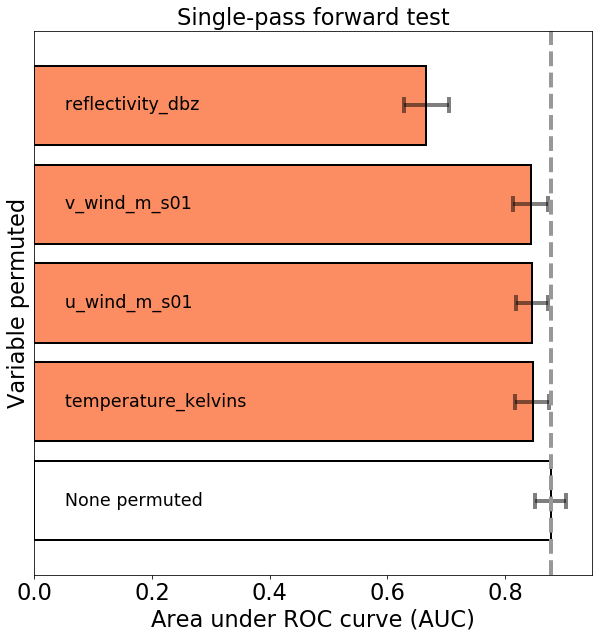

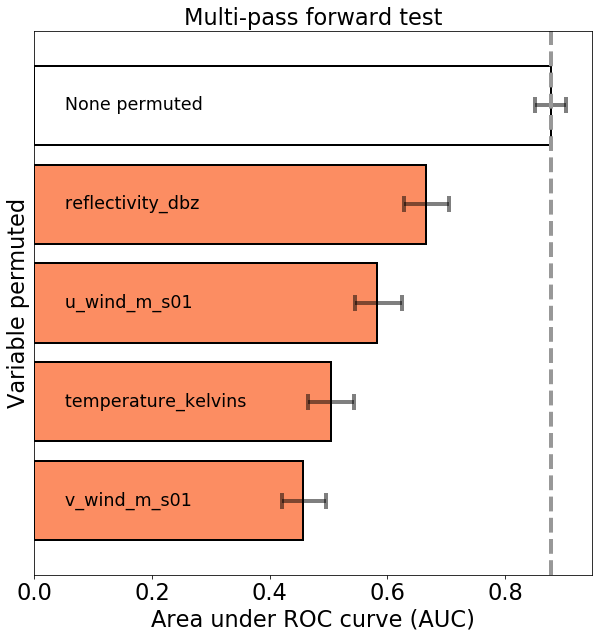

In [15]:
axes_object = permutation.plot_single_pass_test(
    result_dict=permutation_result_dict
)
axes_object.set_title('Single-pass forward test')

axes_object = permutation.plot_multipass_test(
    result_dict=permutation_result_dict
)
axes_object.set_title('Multi-pass forward test')

# Backwards Permutation Test

In [16]:
target_values = binarization.binarize_target_images(
    target_matrix=validation_image_dict[utils.TARGET_MATRIX_KEY],
    binarization_threshold=binarization_threshold
)
clean_predictor_matrix = (
    validation_image_dict[utils.PREDICTOR_MATRIX_KEY] + 0.
)
clean_predictor_matrix, _ = normalization.normalize_images(
    predictor_matrix=clean_predictor_matrix,
    predictor_names=validation_image_dict[utils.PREDICTOR_NAMES_KEY],
    normalization_dict=normalization_dict
)

# permutation_result_dict = permutation.run_backwards_test(
#     model_object=cnn_model_object,
#     clean_predictor_matrix=clean_predictor_matrix,
#     target_values=target_values,
#     predictor_names=validation_image_dict[utils.PREDICTOR_NAMES_KEY]
# )

permutation_result_dict = permutation.run_backwards_test(
    model_object=cnn_model_object,
    clean_predictor_matrix=clean_predictor_matrix[:2000, ...],
    target_values=target_values[:2000],
    predictor_names=validation_image_dict[utils.PREDICTOR_NAMES_KEY]
)

/home/ryan.lagerquist/anaconda3/lib/python3.6/site-packages/ams_2020_ml_python_course-0.1-py3.6.egg/interpretation/permutation.py:414: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  assert numpy.issubdtype(target_values.dtype, int)


Average cost = -0.5445


**************************************************


Unpermuting predictor "reflectivity_dbz" at step 1...
Average cost = -0.7773
Unpermuting predictor "temperature_kelvins" at step 1...
Average cost = -0.5951
Unpermuting predictor "u_wind_m_s01" at step 1...
Average cost = -0.5840
Unpermuting predictor "v_wind_m_s01" at step 1...
Average cost = -0.5845
Best predictor = "reflectivity_dbz" ... cost = -0.7773


**************************************************


Unpermuting predictor "temperature_kelvins" at step 2...
Average cost = -0.8128
Unpermuting predictor "u_wind_m_s01" at step 2...
Average cost = -0.8076
Unpermuting predictor "v_wind_m_s01" at step 2...
Average cost = -0.8069
Best predictor = "temperature_kelvins" ... cost = -0.8128


**************************************************


Unpermuting predictor "u_wind_m_s01" at step 3...
Average cost = -0.8423
Unpermuting predictor "v_wind_m_s01" at step 3...
Average cost = -0.8441
Best predictor = "v_wind

# Backwards Permutation Test

Text(0.5,1,'Multi-pass backwards test')

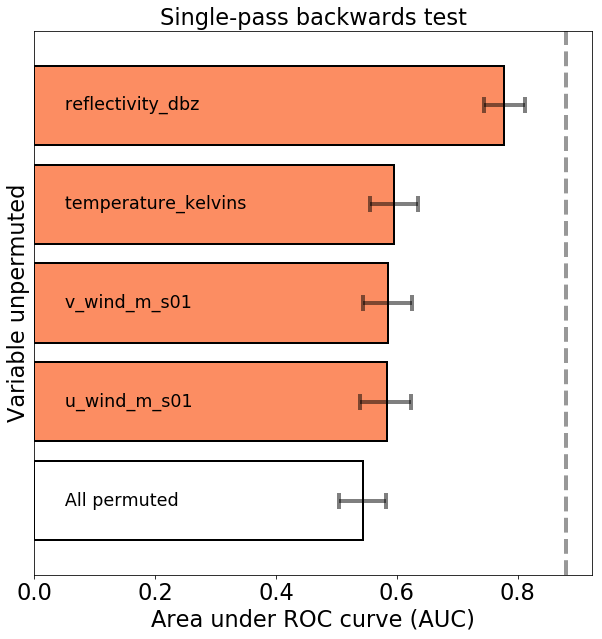

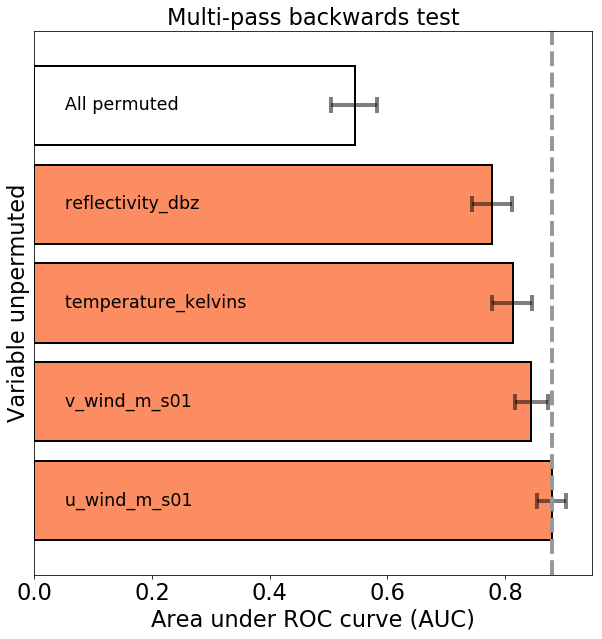

In [17]:
axes_object = permutation.plot_single_pass_test(
    result_dict=permutation_result_dict
)
axes_object.set_title('Single-pass backwards test')

axes_object = permutation.plot_multipass_test(
    result_dict=permutation_result_dict
)
axes_object.set_title('Multi-pass backwards test')

# Saliency Maps

The next cell defines methods that compute saliency maps (Simonyan *et al.* 2014).  Saliency is defined as follows, where $a$ is the activation of some model component; $x$ is an input variable (one predictor at one grid cell); and $x_0$ is the value of $x$ in a real dataset example.

$\textrm{saliency} = \frac{\partial a}{\partial x} \rvert_{x = x_0}$

In other words, saliency is a linear approximation to the derivative $\frac{\partial a}{\partial x}$ around the point $x = x_0$.  Saliency is computed for each predictor $x$ at each grid cell $(i, j)$, so the saliency map for example $E$ has the same dimensions as example $E$.  This makes saliency maps easy to plot.

As for backwards optimization, "some model component" could be any of the following (figure from https://distill.pub/2018/building-blocks/).

 - Neuron activation: spatial position $(i, j)$ in channel $k$ of layer $L$
 - Channel activation: all spatial positions in channel $k$ of layer $L$
 - Layer activation: all spatial positions in all channels of layer $L$
 - Spatial activation: spatial position $(i, j)$ in all channels of layer $L$
 - Final prediction: probability that max future storm vorticity $\ge$ threshold

<img src="model_components.png" alt="Model components" width="1000" />

# Saliency: Example 1

The next cell computes the saliency map for the first validation example with respect to the **positive** class (max future storm vorticity $\ge \zeta^*$).

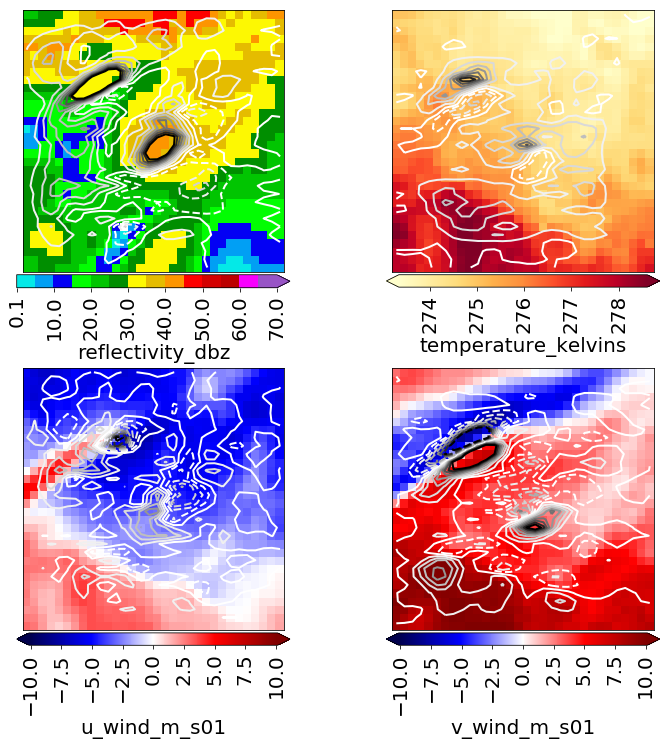

In [22]:
predictor_matrix_denorm = (
    validation_image_dict[utils.PREDICTOR_MATRIX_KEY][0, ...] + 0.
)
predictor_names = validation_image_dict[utils.PREDICTOR_NAMES_KEY]

predictor_matrix_norm, _ = normalization.normalize_images(
    predictor_matrix=predictor_matrix_denorm + 0.,
    predictor_names=predictor_names,
    normalization_dict=normalization_dict
)
predictor_matrix_norm = numpy.expand_dims(predictor_matrix_norm, axis=0)

saliency_matrix = saliency.get_saliency_maps_for_class(
    model_object=cnn_model_object, target_class=1,
    list_of_input_matrices=[predictor_matrix_norm]
)[0][0, ...]

saliency_matrix = saliency.smooth_saliency_maps(
    saliency_matrices=[saliency_matrix], smoothing_radius_grid_cells=1
)[0]

temperature_matrix_kelvins = predictor_matrix_denorm[
    ..., predictor_names.index(utils.TEMPERATURE_NAME)
]
min_temp_kelvins = numpy.percentile(temperature_matrix_kelvins, 1)
max_temp_kelvins = numpy.percentile(temperature_matrix_kelvins, 99)

wind_indices = numpy.array([
    predictor_names.index(utils.U_WIND_NAME),
    predictor_names.index(utils.V_WIND_NAME)
], dtype=int)

max_speed_m_s01 = numpy.percentile(
    numpy.absolute(predictor_matrix_denorm[..., wind_indices]), 99
)

figure_object, axes_object_matrix = (
    plotting.plot_many_predictors_sans_barbs(
        predictor_matrix=predictor_matrix_denorm,
        predictor_names=predictor_names,
        min_colour_temp_kelvins=min_temp_kelvins,
        max_colour_temp_kelvins=max_temp_kelvins,
        max_colour_wind_speed_m_s01=max_speed_m_s01)
)

max_contour_value = numpy.percentile(numpy.absolute(saliency_matrix), 99)

saliency.plot_saliency_maps(
    saliency_matrix_3d=saliency_matrix,
    axes_object_matrix=axes_object_matrix,
    colour_map_object=pyplot.get_cmap('Greys'),
    max_contour_value=max_contour_value,
    contour_interval=max_contour_value / 8
)

# Saliency: Example 2

The next cell computes the saliency map for the first validation example with respect to the **negative** class (max future storm vorticity $< \zeta^*$).

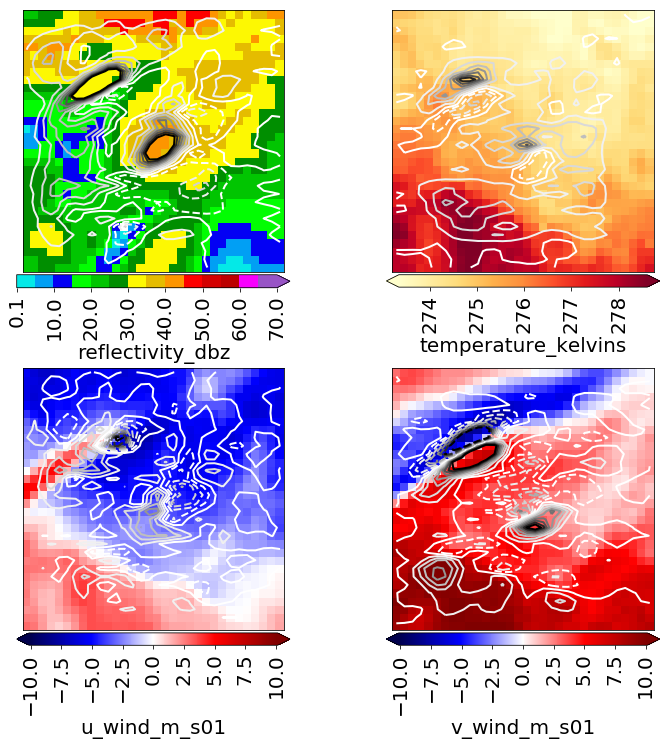

In [15]:
predictor_matrix_denorm = (
    validation_image_dict[utils.PREDICTOR_MATRIX_KEY][0, ...] + 0.
)
predictor_names = validation_image_dict[utils.PREDICTOR_NAMES_KEY]

predictor_matrix_norm, _ = normalization.normalize_images(
    predictor_matrix=predictor_matrix_denorm + 0.,
    predictor_names=predictor_names,
    normalization_dict=normalization_dict
)
predictor_matrix_norm = numpy.expand_dims(predictor_matrix_norm, axis=0)

saliency_matrix = saliency.get_saliency_maps_for_class(
    model_object=cnn_model_object, target_class=1,
    list_of_input_matrices=[predictor_matrix_norm]
)[0][0, ...]

saliency_matrix = saliency.smooth_saliency_maps(
    saliency_matrices=[saliency_matrix], smoothing_radius_grid_cells=1
)[0]

temperature_matrix_kelvins = predictor_matrix_denorm[
    ..., predictor_names.index(utils.TEMPERATURE_NAME)
]
min_temp_kelvins = numpy.percentile(temperature_matrix_kelvins, 1)
max_temp_kelvins = numpy.percentile(temperature_matrix_kelvins, 99)

wind_indices = numpy.array([
    predictor_names.index(utils.U_WIND_NAME),
    predictor_names.index(utils.V_WIND_NAME)
], dtype=int)

max_speed_m_s01 = numpy.percentile(
    numpy.absolute(predictor_matrix_denorm[..., wind_indices]), 99
)

figure_object, axes_object_matrix = (
    plotting.plot_many_predictors_sans_barbs(
        predictor_matrix=predictor_matrix_denorm,
        predictor_names=predictor_names,
        min_colour_temp_kelvins=min_temp_kelvins,
        max_colour_temp_kelvins=max_temp_kelvins,
        max_colour_wind_speed_m_s01=max_speed_m_s01)
)

max_contour_value = numpy.percentile(numpy.absolute(saliency_matrix), 99)

saliency.plot_saliency_maps(
    saliency_matrix_3d=saliency_matrix,
    axes_object_matrix=axes_object_matrix,
    colour_map_object=pyplot.get_cmap('Greys'),
    max_contour_value=max_contour_value,
    contour_interval=max_contour_value / 8
)

# Saliency: Example 3

The next cell computes the saliency map for the most extreme validation example (greatest future vorticity) with respect to the **positive** class (max future storm vorticity $\ge \zeta^*$).

/home/ryan.lagerquist/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:1173: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


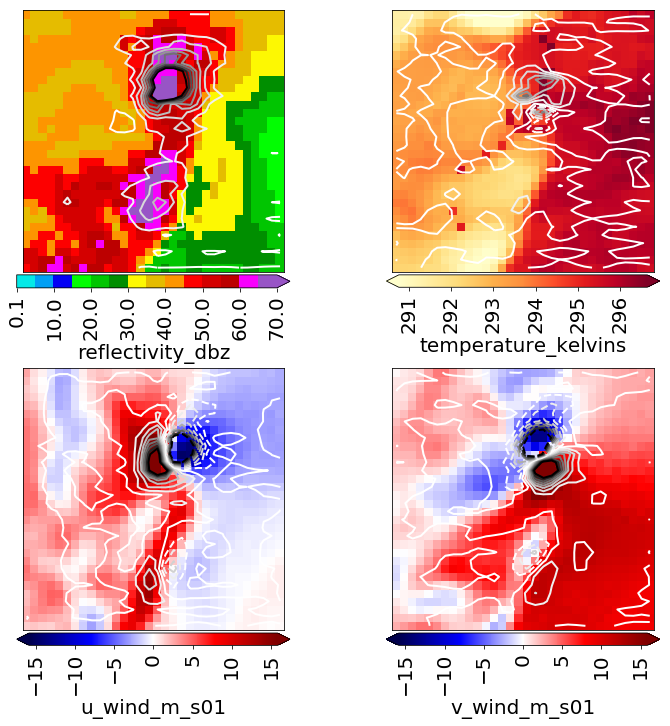

In [16]:
target_matrix_s01 = validation_image_dict[utils.TARGET_MATRIX_KEY]
example_index = numpy.unravel_index(
    numpy.argmax(target_matrix_s01), target_matrix_s01.shape
)[0]

predictor_matrix_denorm = (
    validation_image_dict[utils.PREDICTOR_MATRIX_KEY][example_index, ...]
    + 0.
)
predictor_names = validation_image_dict[utils.PREDICTOR_NAMES_KEY]

predictor_matrix_norm, _ = normalization.normalize_images(
    predictor_matrix=predictor_matrix_denorm + 0.,
    predictor_names=predictor_names,
    normalization_dict=normalization_dict
)
predictor_matrix_norm = numpy.expand_dims(predictor_matrix_norm, axis=0)

saliency_matrix = saliency.get_saliency_maps_for_class(
    model_object=cnn_model_object, target_class=1,
    list_of_input_matrices=[predictor_matrix_norm]
)[0][0, ...]

saliency_matrix = saliency.smooth_saliency_maps(
    saliency_matrices=[saliency_matrix], smoothing_radius_grid_cells=1
)[0]

temperature_matrix_kelvins = predictor_matrix_denorm[
    ..., predictor_names.index(utils.TEMPERATURE_NAME)
]
min_temp_kelvins = numpy.percentile(temperature_matrix_kelvins, 1)
max_temp_kelvins = numpy.percentile(temperature_matrix_kelvins, 99)

wind_indices = numpy.array([
    predictor_names.index(utils.U_WIND_NAME),
    predictor_names.index(utils.V_WIND_NAME)
], dtype=int)

max_speed_m_s01 = numpy.percentile(
    numpy.absolute(predictor_matrix_denorm[..., wind_indices]), 99
)

figure_object, axes_object_matrix = (
    plotting.plot_many_predictors_sans_barbs(
        predictor_matrix=predictor_matrix_denorm,
        predictor_names=predictor_names,
        min_colour_temp_kelvins=min_temp_kelvins,
        max_colour_temp_kelvins=max_temp_kelvins,
        max_colour_wind_speed_m_s01=max_speed_m_s01)
)

max_contour_value = numpy.percentile(numpy.absolute(saliency_matrix), 99)

saliency.plot_saliency_maps(
    saliency_matrix_3d=saliency_matrix,
    axes_object_matrix=axes_object_matrix,
    colour_map_object=pyplot.get_cmap('Greys'),
    max_contour_value=max_contour_value,
    contour_interval=max_contour_value / 8
)

# Saliency: Example 4

The next cell computes the saliency map for the most extreme validation example (greatest future vorticity) with respect to the **negative** class (max future storm vorticity $< \zeta^*$).

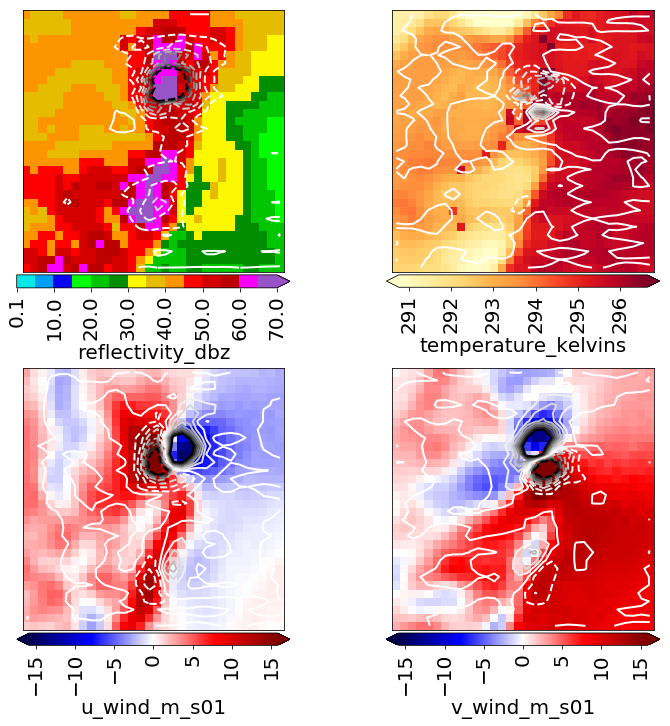

In [17]:
target_matrix_s01 = validation_image_dict[utils.TARGET_MATRIX_KEY]
example_index = numpy.unravel_index(
    numpy.argmax(target_matrix_s01), target_matrix_s01.shape
)[0]

predictor_matrix_denorm = (
    validation_image_dict[utils.PREDICTOR_MATRIX_KEY][example_index, ...]
    + 0.
)
predictor_names = validation_image_dict[utils.PREDICTOR_NAMES_KEY]

predictor_matrix_norm, _ = normalization.normalize_images(
    predictor_matrix=predictor_matrix_denorm + 0.,
    predictor_names=predictor_names,
    normalization_dict=normalization_dict
)
predictor_matrix_norm = numpy.expand_dims(predictor_matrix_norm, axis=0)

saliency_matrix = saliency.get_saliency_maps_for_class(
    model_object=cnn_model_object, target_class=0,
    list_of_input_matrices=[predictor_matrix_norm]
)[0][0, ...]

saliency_matrix = saliency.smooth_saliency_maps(
    saliency_matrices=[saliency_matrix], smoothing_radius_grid_cells=1
)[0]

temperature_matrix_kelvins = predictor_matrix_denorm[
    ..., predictor_names.index(utils.TEMPERATURE_NAME)
]
min_temp_kelvins = numpy.percentile(temperature_matrix_kelvins, 1)
max_temp_kelvins = numpy.percentile(temperature_matrix_kelvins, 99)

wind_indices = numpy.array([
    predictor_names.index(utils.U_WIND_NAME),
    predictor_names.index(utils.V_WIND_NAME)
], dtype=int)

max_speed_m_s01 = numpy.percentile(
    numpy.absolute(predictor_matrix_denorm[..., wind_indices]), 99
)

figure_object, axes_object_matrix = (
    plotting.plot_many_predictors_sans_barbs(
        predictor_matrix=predictor_matrix_denorm,
        predictor_names=predictor_names,
        min_colour_temp_kelvins=min_temp_kelvins,
        max_colour_temp_kelvins=max_temp_kelvins,
        max_colour_wind_speed_m_s01=max_speed_m_s01)
)

max_contour_value = numpy.percentile(numpy.absolute(saliency_matrix), 99)

saliency.plot_saliency_maps(
    saliency_matrix_3d=saliency_matrix,
    axes_object_matrix=axes_object_matrix,
    colour_map_object=pyplot.get_cmap('Greys'),
    max_contour_value=max_contour_value,
    contour_interval=max_contour_value / 8
)

# Find Extreme Cases

In [15]:
predictor_matrix_denorm = (
    validation_image_dict[utils.PREDICTOR_MATRIX_KEY] + 0.
)
predictor_names = validation_image_dict[utils.PREDICTOR_NAMES_KEY]

predictor_matrix_norm, _ = normalization.normalize_images(
    predictor_matrix=predictor_matrix_denorm + 0.,
    predictor_names=predictor_names,
    normalization_dict=normalization_dict
)

validation_event_probs = cnn.apply_cnn(
    model_object=cnn_model_object, predictor_matrix=predictor_matrix_norm,
    verbose=True
)
print('\n')

target_values = binarization.binarize_target_images(
    target_matrix=validation_image_dict[utils.TARGET_MATRIX_KEY],
    binarization_threshold=binarization_threshold
)

this_dict = utils.find_extreme_examples(
    class_labels=target_values, event_probabilities=validation_event_probs,
    num_examples_per_set=100
)
best_hit_indices = this_dict[utils.HIT_INDICES_KEY]
worst_false_alarm_indices = this_dict[utils.FALSE_ALARM_INDICES_KEY]
worst_miss_indices = this_dict[utils.MISS_INDICES_KEY]
best_correct_null_indices = this_dict[utils.CORRECT_NULL_INDICES_KEY]

extreme_example_dict_denorm = {
    BEST_HIT_MATRIX_KEY: predictor_matrix_denorm[best_hit_indices, ...],
    WORST_FALSE_ALARM_MATRIX_KEY:
        predictor_matrix_denorm[worst_false_alarm_indices, ...],
    WORST_MISS_MATRIX_KEY:
        predictor_matrix_denorm[worst_miss_indices, ...],
    BEST_CORRECT_NULLS_MATRIX_KEY:
        predictor_matrix_denorm[best_correct_null_indices, ...],
    PREDICTOR_NAMES_KEY: predictor_names
}

extreme_example_dict_norm = {
    BEST_HIT_MATRIX_KEY: predictor_matrix_norm[best_hit_indices, ...],
    WORST_FALSE_ALARM_MATRIX_KEY:
        predictor_matrix_norm[worst_false_alarm_indices, ...],
    WORST_MISS_MATRIX_KEY:
        predictor_matrix_norm[worst_miss_indices, ...],
    BEST_CORRECT_NULLS_MATRIX_KEY:
        predictor_matrix_norm[best_correct_null_indices, ...],
    PREDICTOR_NAMES_KEY: predictor_names
}

this_bh_matrix = utils.run_pmm_many_variables(
    field_matrix=extreme_example_dict_denorm[BEST_HIT_MATRIX_KEY]
)
this_wfa_matrix = utils.run_pmm_many_variables(
    field_matrix=extreme_example_dict_denorm[WORST_FALSE_ALARM_MATRIX_KEY]
)
this_wm_matrix = utils.run_pmm_many_variables(
    field_matrix=extreme_example_dict_denorm[WORST_MISS_MATRIX_KEY]
)
this_bcn_matrix = utils.run_pmm_many_variables(
    field_matrix=extreme_example_dict_denorm[BEST_CORRECT_NULLS_MATRIX_KEY]
)

extreme_example_dict_denorm_pmm = {
    BEST_HIT_MATRIX_KEY: this_bh_matrix,
    WORST_FALSE_ALARM_MATRIX_KEY: this_wfa_matrix,
    WORST_MISS_MATRIX_KEY: this_wm_matrix,
    BEST_CORRECT_NULLS_MATRIX_KEY: this_bcn_matrix,
    PREDICTOR_NAMES_KEY: predictor_names
}

Applying model to examples 0-999 of 25392...
Applying model to examples 1000-1999 of 25392...
Applying model to examples 2000-2999 of 25392...
Applying model to examples 3000-3999 of 25392...
Applying model to examples 4000-4999 of 25392...
Applying model to examples 5000-5999 of 25392...
Applying model to examples 6000-6999 of 25392...
Applying model to examples 7000-7999 of 25392...
Applying model to examples 8000-8999 of 25392...
Applying model to examples 9000-9999 of 25392...
Applying model to examples 10000-10999 of 25392...
Applying model to examples 11000-11999 of 25392...
Applying model to examples 12000-12999 of 25392...
Applying model to examples 13000-13999 of 25392...
Applying model to examples 14000-14999 of 25392...
Applying model to examples 15000-15999 of 25392...
Applying model to examples 16000-16999 of 25392...
Applying model to examples 17000-17999 of 25392...
Applying model to examples 18000-18999 of 25392...
Applying model to examples 19000-19999 of 25392...
Appl

# Saliency: Example 5

/home/ryan.lagerquist/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:1173: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


Text(0.5,0.98,'Saliency for best correct nulls')

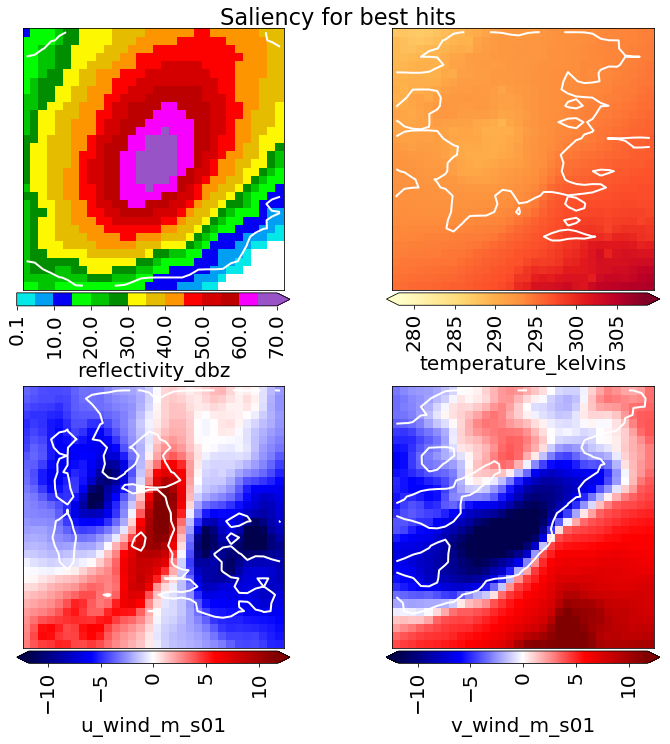

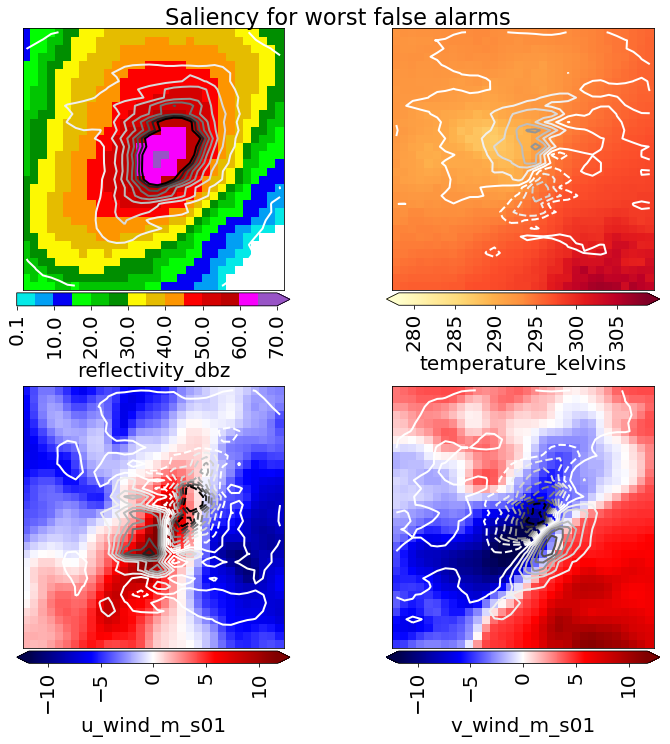

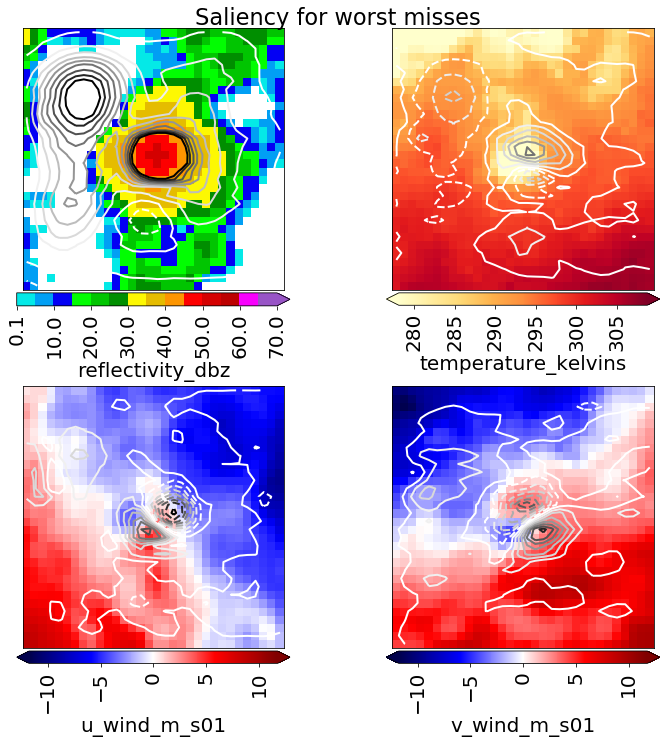

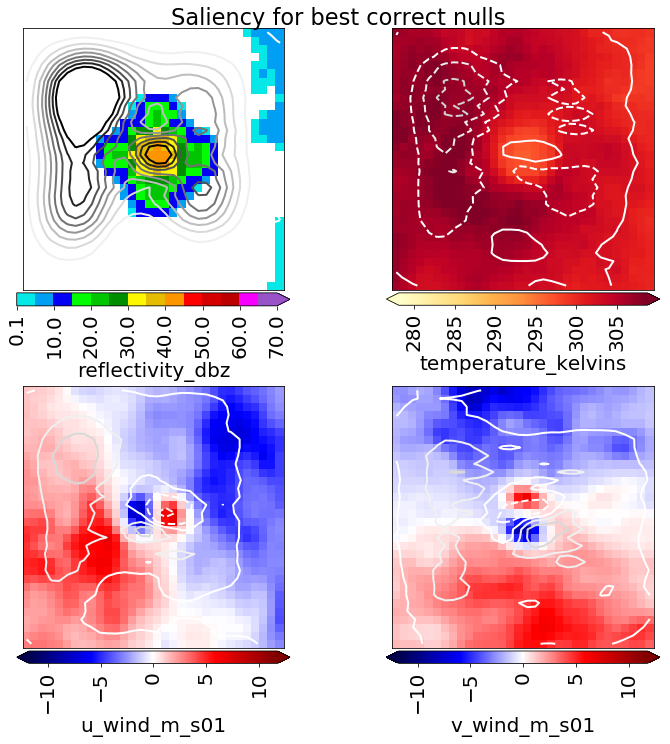

In [16]:
best_hits_saliency_matrix = saliency.get_saliency_maps_for_class(
    model_object=cnn_model_object, target_class=1,
    list_of_input_matrices=[extreme_example_dict_norm[BEST_HIT_MATRIX_KEY]]
)[0]
best_hits_saliency_matrix_pmm = utils.run_pmm_many_variables(
    field_matrix=best_hits_saliency_matrix
)
best_hits_saliency_matrix_pmm = saliency.smooth_saliency_maps(
    saliency_matrices=[best_hits_saliency_matrix_pmm],
    smoothing_radius_grid_cells=1
)[0]

worst_fa_saliency_matrix = saliency.get_saliency_maps_for_class(
    model_object=cnn_model_object, target_class=1,
    list_of_input_matrices=
    [extreme_example_dict_norm[WORST_FALSE_ALARM_MATRIX_KEY]]
)[0]
worst_fa_saliency_matrix_pmm = utils.run_pmm_many_variables(
    field_matrix=worst_fa_saliency_matrix
)
worst_fa_saliency_matrix_pmm = saliency.smooth_saliency_maps(
    saliency_matrices=[worst_fa_saliency_matrix_pmm],
    smoothing_radius_grid_cells=1
)[0]

worst_misses_saliency_matrix = saliency.get_saliency_maps_for_class(
    model_object=cnn_model_object, target_class=1,
    list_of_input_matrices=
    [extreme_example_dict_norm[WORST_MISS_MATRIX_KEY]]
)[0]
worst_misses_saliency_matrix_pmm = utils.run_pmm_many_variables(
    field_matrix=worst_misses_saliency_matrix
)
worst_misses_saliency_matrix_pmm = saliency.smooth_saliency_maps(
    saliency_matrices=[worst_misses_saliency_matrix_pmm],
    smoothing_radius_grid_cells=1
)[0]

best_nulls_saliency_matrix = saliency.get_saliency_maps_for_class(
    model_object=cnn_model_object, target_class=1,
    list_of_input_matrices=
    [extreme_example_dict_norm[BEST_CORRECT_NULLS_MATRIX_KEY]]
)[0]
best_nulls_saliency_matrix_pmm = utils.run_pmm_many_variables(
    field_matrix=best_nulls_saliency_matrix
)
best_nulls_saliency_matrix_pmm = saliency.smooth_saliency_maps(
    saliency_matrices=[best_nulls_saliency_matrix_pmm],
    smoothing_radius_grid_cells=1
)[0]

best_hits_matrix_denorm_pmm = extreme_example_dict_denorm_pmm[
    BEST_HIT_MATRIX_KEY
]
worst_fa_matrix_denorm_pmm = extreme_example_dict_denorm_pmm[
    WORST_FALSE_ALARM_MATRIX_KEY
]
worst_misses_matrix_denorm_pmm = extreme_example_dict_denorm_pmm[
    WORST_MISS_MATRIX_KEY
]
best_nulls_matrix_denorm_pmm = extreme_example_dict_denorm_pmm[
    BEST_CORRECT_NULLS_MATRIX_KEY
]
predictor_names = extreme_example_dict_denorm_pmm[PREDICTOR_NAMES_KEY]

concat_predictor_matrix = numpy.stack((
    best_hits_matrix_denorm_pmm, worst_fa_matrix_denorm_pmm,
    worst_misses_matrix_denorm_pmm, best_nulls_matrix_denorm_pmm,
), axis=0)

temperature_matrix_kelvins = concat_predictor_matrix[
    ..., predictor_names.index(utils.TEMPERATURE_NAME)
]
min_temp_kelvins = numpy.percentile(temperature_matrix_kelvins, 1)
max_temp_kelvins = numpy.percentile(temperature_matrix_kelvins, 99)

wind_indices = numpy.array([
    predictor_names.index(utils.U_WIND_NAME),
    predictor_names.index(utils.V_WIND_NAME)
], dtype=int)

max_speed_m_s01 = numpy.percentile(
    numpy.absolute(concat_predictor_matrix[..., wind_indices]), 99
)

concat_saliency_matrix = numpy.stack((
    best_hits_saliency_matrix_pmm, worst_fa_saliency_matrix_pmm,
    worst_misses_saliency_matrix_pmm, best_nulls_saliency_matrix_pmm,
), axis=0)

max_saliency = numpy.percentile(numpy.absolute(concat_saliency_matrix), 99)

figure_object, axes_object_matrix = (
    plotting.plot_many_predictors_sans_barbs(
        predictor_matrix=best_hits_matrix_denorm_pmm,
        predictor_names=predictor_names,
        min_colour_temp_kelvins=min_temp_kelvins,
        max_colour_temp_kelvins=max_temp_kelvins,
        max_colour_wind_speed_m_s01=max_speed_m_s01)
)

saliency.plot_saliency_maps(
    saliency_matrix_3d=best_hits_saliency_matrix_pmm,
    axes_object_matrix=axes_object_matrix,
    colour_map_object=pyplot.get_cmap('Greys'),
    max_contour_value=max_saliency,
    contour_interval=max_saliency / 8
)

figure_object.suptitle('Saliency for best hits')

figure_object, axes_object_matrix = (
    plotting.plot_many_predictors_sans_barbs(
        predictor_matrix=worst_fa_matrix_denorm_pmm,
        predictor_names=predictor_names,
        min_colour_temp_kelvins=min_temp_kelvins,
        max_colour_temp_kelvins=max_temp_kelvins,
        max_colour_wind_speed_m_s01=max_speed_m_s01)
)

saliency.plot_saliency_maps(
    saliency_matrix_3d=worst_fa_saliency_matrix_pmm,
    axes_object_matrix=axes_object_matrix,
    colour_map_object=pyplot.get_cmap('Greys'),
    max_contour_value=max_saliency,
    contour_interval=max_saliency / 8
)

figure_object.suptitle('Saliency for worst false alarms')

figure_object, axes_object_matrix = (
    plotting.plot_many_predictors_sans_barbs(
        predictor_matrix=worst_misses_matrix_denorm_pmm,
        predictor_names=predictor_names,
        min_colour_temp_kelvins=min_temp_kelvins,
        max_colour_temp_kelvins=max_temp_kelvins,
        max_colour_wind_speed_m_s01=max_speed_m_s01)
)

saliency.plot_saliency_maps(
    saliency_matrix_3d=worst_misses_saliency_matrix_pmm,
    axes_object_matrix=axes_object_matrix,
    colour_map_object=pyplot.get_cmap('Greys'),
    max_contour_value=max_saliency,
    contour_interval=max_saliency / 8
)

figure_object.suptitle('Saliency for worst misses')

figure_object, axes_object_matrix = (
    plotting.plot_many_predictors_sans_barbs(
        predictor_matrix=best_nulls_matrix_denorm_pmm,
        predictor_names=predictor_names,
        min_colour_temp_kelvins=min_temp_kelvins,
        max_colour_temp_kelvins=max_temp_kelvins,
        max_colour_wind_speed_m_s01=max_speed_m_s01)
)

saliency.plot_saliency_maps(
    saliency_matrix_3d=best_nulls_saliency_matrix_pmm,
    axes_object_matrix=axes_object_matrix,
    colour_map_object=pyplot.get_cmap('Greys'),
    max_contour_value=max_saliency,
    contour_interval=max_saliency / 8
)

figure_object.suptitle('Saliency for best correct nulls')

# Class Activation: Example 1

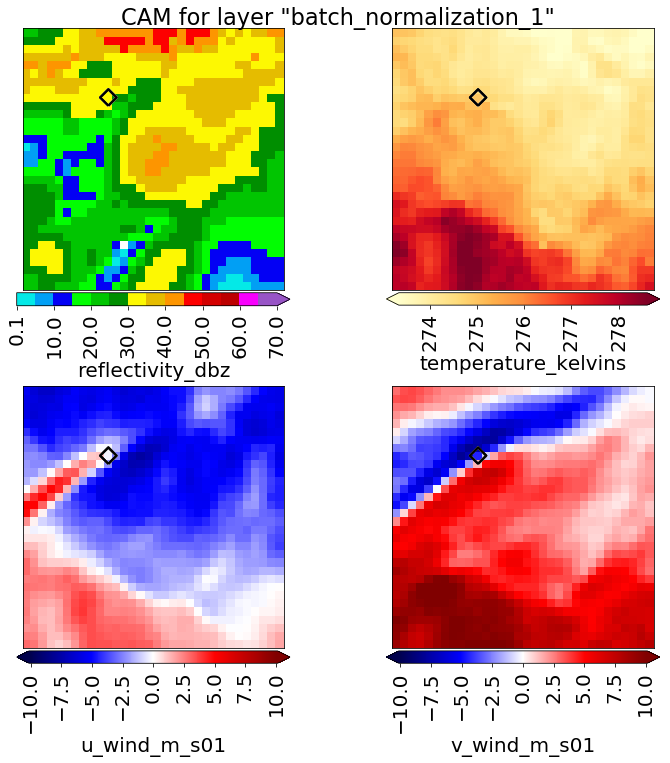

/home/ryan.lagerquist/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:1173: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


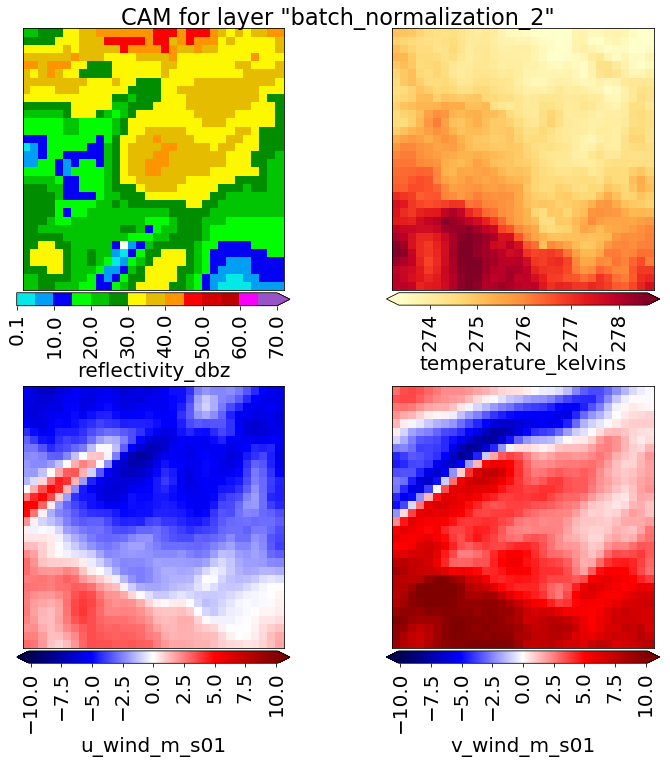

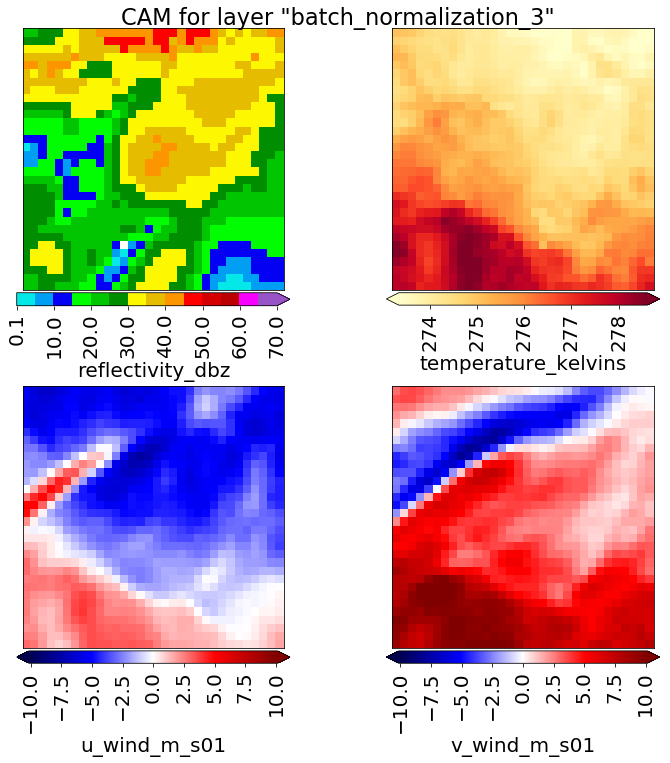

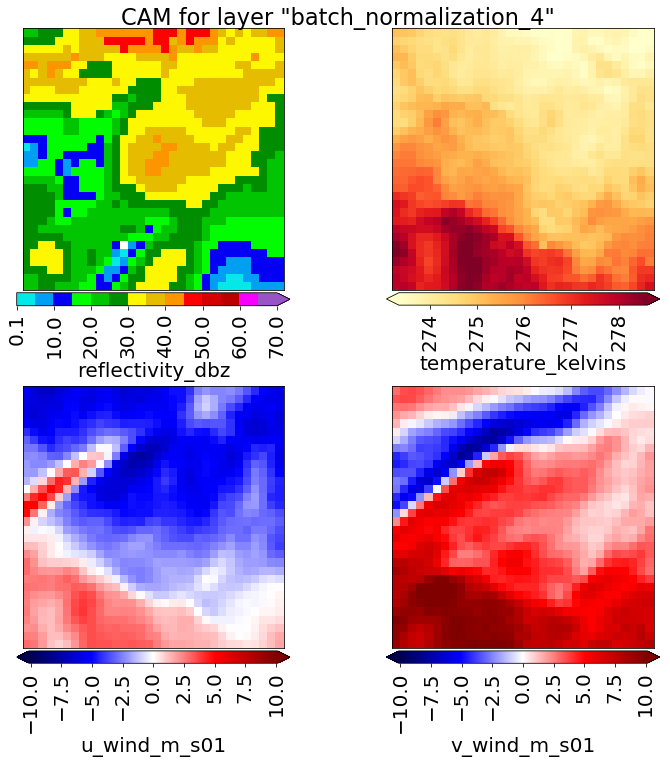

In [17]:
predictor_matrix_denorm = (
    validation_image_dict[utils.PREDICTOR_MATRIX_KEY][0, ...] + 0.
)
predictor_names = validation_image_dict[utils.PREDICTOR_NAMES_KEY]

predictor_matrix_norm, _ = normalization.normalize_images(
    predictor_matrix=predictor_matrix_denorm + 0.,
    predictor_names=predictor_names,
    normalization_dict=normalization_dict
)

temperature_matrix_kelvins = predictor_matrix_denorm[
    ..., predictor_names.index(utils.TEMPERATURE_NAME)
]
min_temp_kelvins = numpy.percentile(temperature_matrix_kelvins, 1)
max_temp_kelvins = numpy.percentile(temperature_matrix_kelvins, 99)

wind_indices = numpy.array([
    predictor_names.index(utils.U_WIND_NAME),
    predictor_names.index(utils.V_WIND_NAME)
], dtype=int)

max_speed_m_s01 = numpy.percentile(
    numpy.absolute(predictor_matrix_denorm[..., wind_indices]), 99
)

target_layer_names = [
    'batch_normalization_1', 'batch_normalization_2',
    'batch_normalization_3', 'batch_normalization_4'
]

for this_layer_name in target_layer_names:
    class_activation_matrix = class_activation.run_gradcam(
        model_object=cnn_model_object, input_matrix=predictor_matrix_norm,
        target_class=1, target_layer_name=this_layer_name
    )

    figure_object, axes_object_matrix = (
        plotting.plot_many_predictors_sans_barbs(
            predictor_matrix=predictor_matrix_denorm,
            predictor_names=predictor_names,
            min_colour_temp_kelvins=min_temp_kelvins,
            max_colour_temp_kelvins=max_temp_kelvins,
            max_colour_wind_speed_m_s01=max_speed_m_s01)
    )

    max_contour_value = numpy.percentile(class_activation_matrix, 99)

    class_activation.plot_2d_cam(
        class_activation_matrix_2d=class_activation_matrix,
        axes_object_matrix=axes_object_matrix,
        num_channels=predictor_matrix_norm.shape[-1],
        colour_map_object=pyplot.get_cmap('Greys'),
        min_contour_value=max_contour_value / 15,
        max_contour_value=max_contour_value,
        contour_interval=max_contour_value / 15
    )

    figure_object.suptitle(
        'CAM for layer "{0:s}"'.format(this_layer_name)
    )
    pyplot.show()

# Class Activation: Example 2

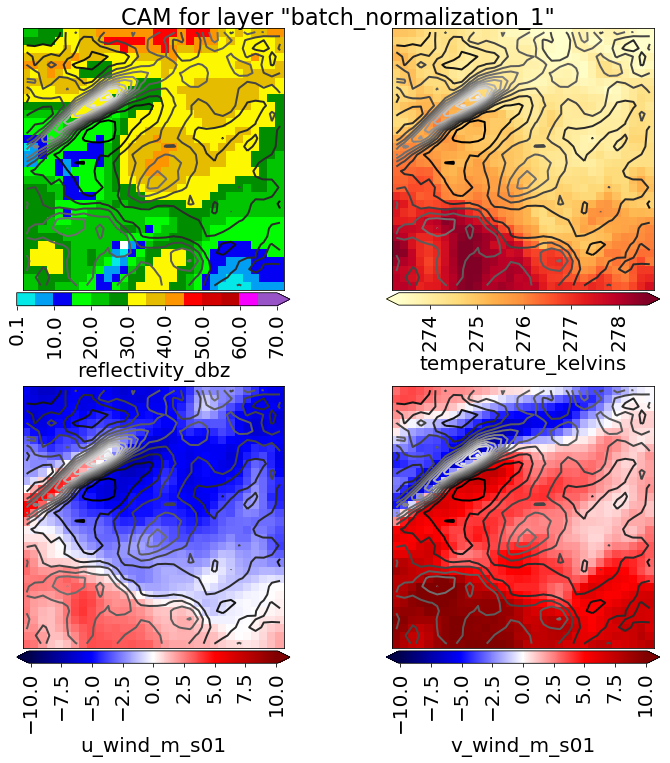

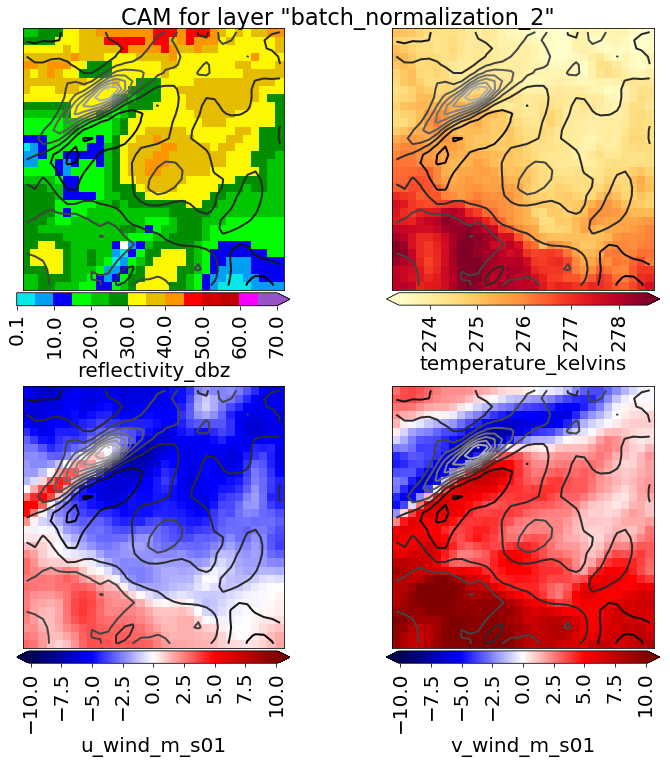

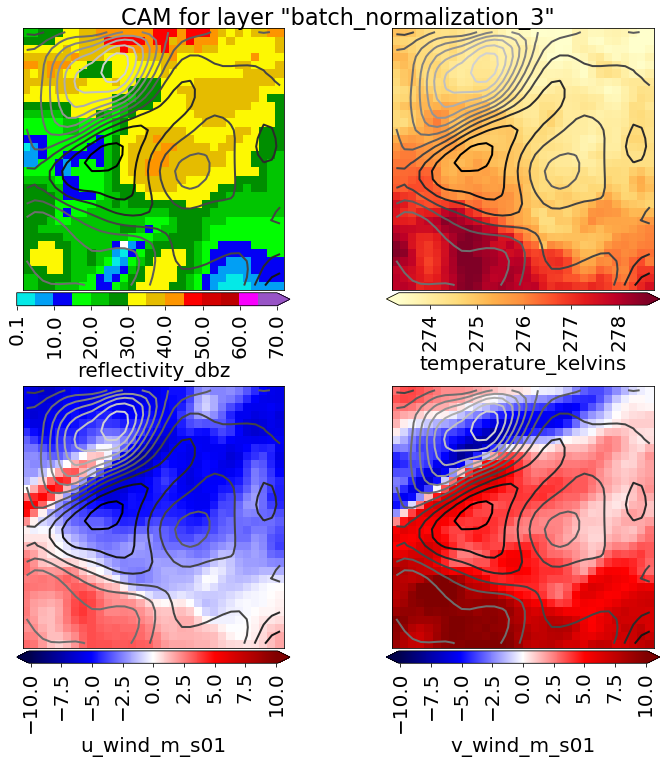

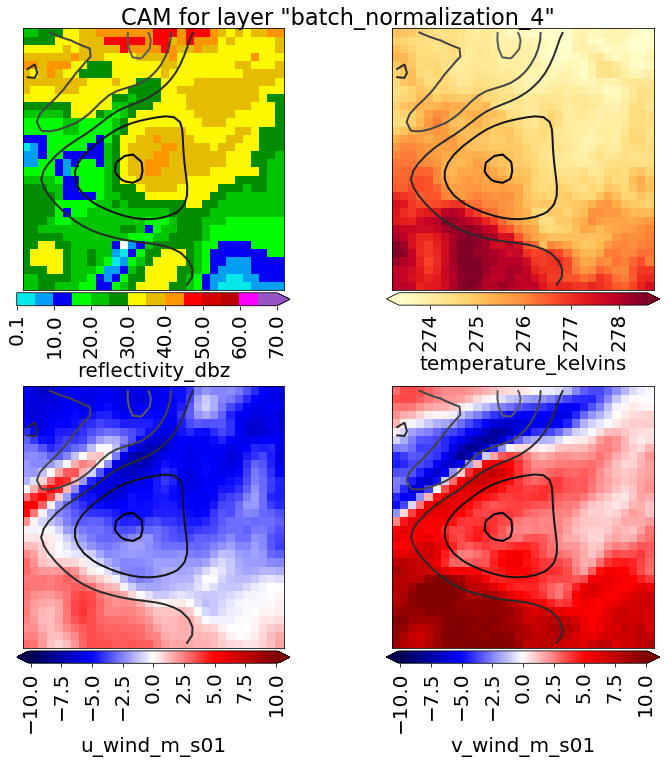

In [22]:
predictor_matrix_denorm = (
    validation_image_dict[utils.PREDICTOR_MATRIX_KEY][0, ...] + 0.
)
predictor_names = validation_image_dict[utils.PREDICTOR_NAMES_KEY]

predictor_matrix_norm, _ = normalization.normalize_images(
    predictor_matrix=predictor_matrix_denorm + 0.,
    predictor_names=predictor_names,
    normalization_dict=normalization_dict
)

temperature_matrix_kelvins = predictor_matrix_denorm[
    ..., predictor_names.index(utils.TEMPERATURE_NAME)
]
min_temp_kelvins = numpy.percentile(temperature_matrix_kelvins, 1)
max_temp_kelvins = numpy.percentile(temperature_matrix_kelvins, 99)

wind_indices = numpy.array([
    predictor_names.index(utils.U_WIND_NAME),
    predictor_names.index(utils.V_WIND_NAME)
], dtype=int)

max_speed_m_s01 = numpy.percentile(
    numpy.absolute(predictor_matrix_denorm[..., wind_indices]), 99
)

target_layer_names = [
    'batch_normalization_1', 'batch_normalization_2',
    'batch_normalization_3', 'batch_normalization_4'
]

for this_layer_name in target_layer_names:
    class_activation_matrix = class_activation.run_gradcam(
        model_object=cnn_model_object, input_matrix=predictor_matrix_norm,
        target_class=0, target_layer_name=this_layer_name
    )

    figure_object, axes_object_matrix = (
        plotting.plot_many_predictors_sans_barbs(
            predictor_matrix=predictor_matrix_denorm,
            predictor_names=predictor_names,
            min_colour_temp_kelvins=min_temp_kelvins,
            max_colour_temp_kelvins=max_temp_kelvins,
            max_colour_wind_speed_m_s01=max_speed_m_s01)
    )

    max_contour_value = numpy.percentile(class_activation_matrix, 99)

    class_activation.plot_2d_cam(
        class_activation_matrix_2d=class_activation_matrix,
        axes_object_matrix=axes_object_matrix,
        num_channels=predictor_matrix_norm.shape[-1],
        colour_map_object=pyplot.get_cmap('Greys'),
        min_contour_value=max_contour_value / 15,
        max_contour_value=max_contour_value,
        contour_interval=max_contour_value / 15
    )

    figure_object.suptitle(
        'CAM for layer "{0:s}"'.format(this_layer_name)
    )
    pyplot.show()

# Class Activation: Example 3

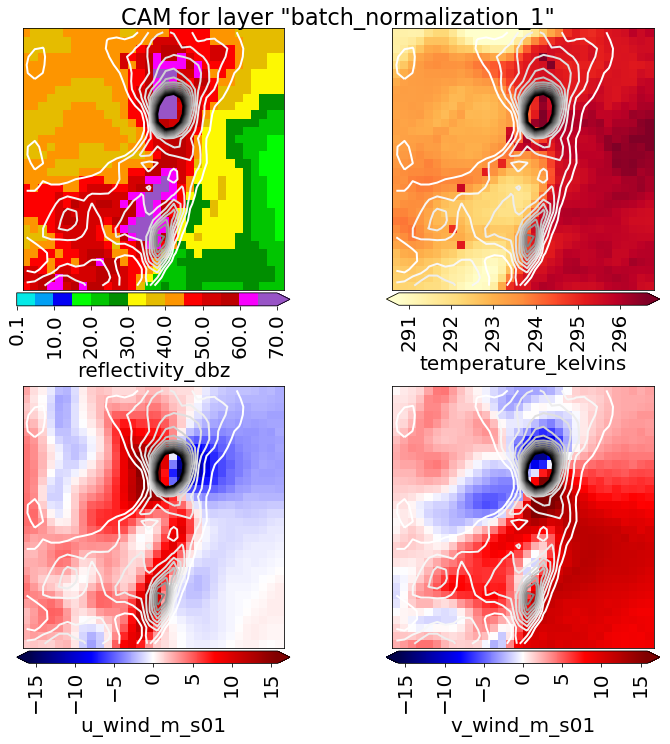

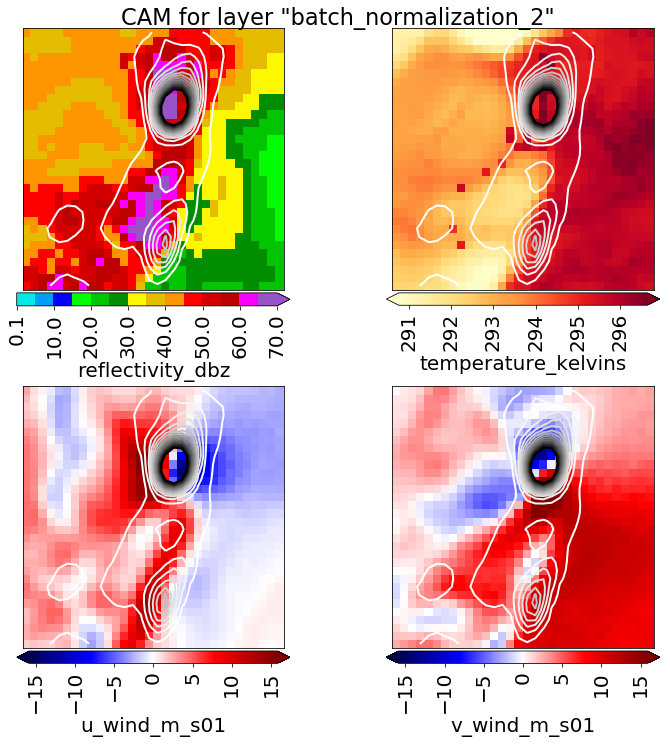

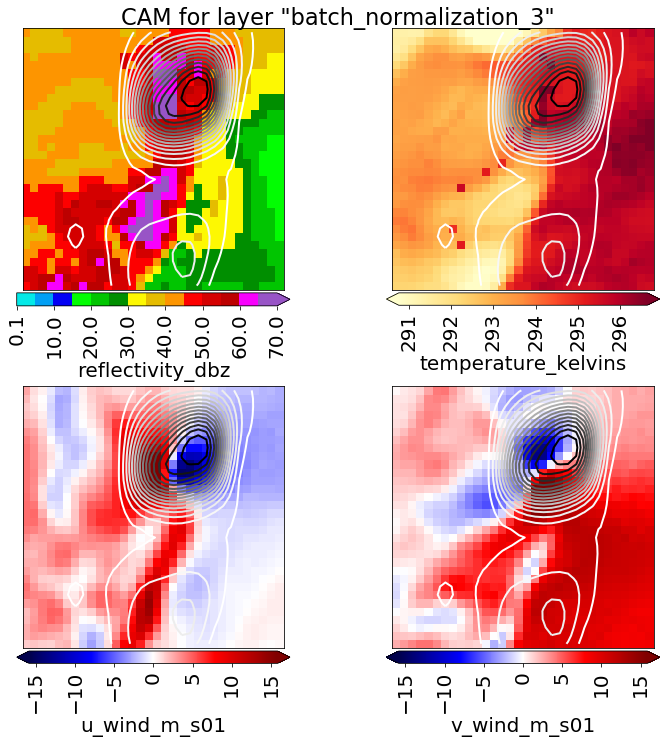

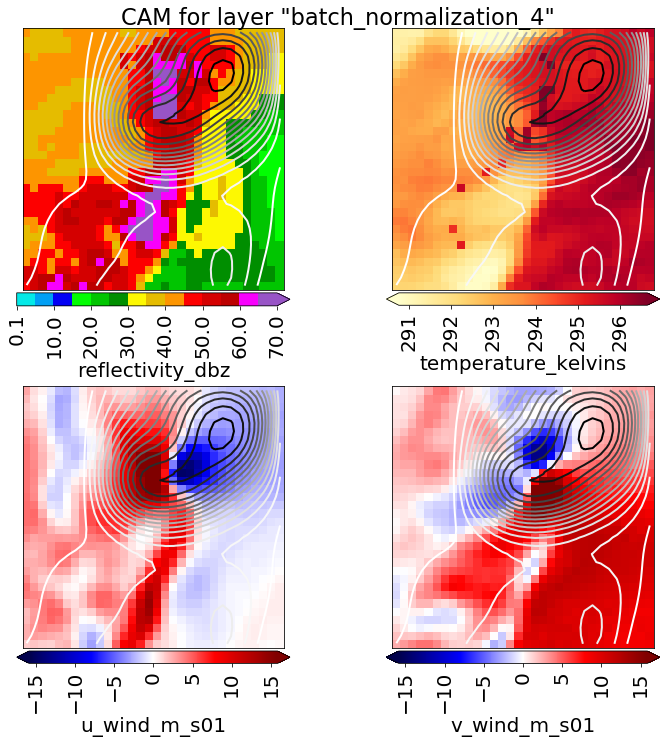

In [23]:
target_matrix_s01 = validation_image_dict[utils.TARGET_MATRIX_KEY]
example_index = numpy.unravel_index(
    numpy.argmax(target_matrix_s01), target_matrix_s01.shape
)[0]

predictor_matrix_denorm = (
    validation_image_dict[utils.PREDICTOR_MATRIX_KEY][example_index, ...]
    + 0.
)
predictor_names = validation_image_dict[utils.PREDICTOR_NAMES_KEY]

predictor_matrix_norm, _ = normalization.normalize_images(
    predictor_matrix=predictor_matrix_denorm + 0.,
    predictor_names=predictor_names,
    normalization_dict=normalization_dict
)

temperature_matrix_kelvins = predictor_matrix_denorm[
    ..., predictor_names.index(utils.TEMPERATURE_NAME)
]
min_temp_kelvins = numpy.percentile(temperature_matrix_kelvins, 1)
max_temp_kelvins = numpy.percentile(temperature_matrix_kelvins, 99)

wind_indices = numpy.array([
    predictor_names.index(utils.U_WIND_NAME),
    predictor_names.index(utils.V_WIND_NAME)
], dtype=int)

max_speed_m_s01 = numpy.percentile(
    numpy.absolute(predictor_matrix_denorm[..., wind_indices]), 99
)

target_layer_names = [
    'batch_normalization_1', 'batch_normalization_2',
    'batch_normalization_3', 'batch_normalization_4'
]

for this_layer_name in target_layer_names:
    class_activation_matrix = class_activation.run_gradcam(
        model_object=cnn_model_object, input_matrix=predictor_matrix_norm,
        target_class=1, target_layer_name=this_layer_name
    )

    figure_object, axes_object_matrix = (
        plotting.plot_many_predictors_sans_barbs(
            predictor_matrix=predictor_matrix_denorm,
            predictor_names=predictor_names,
            min_colour_temp_kelvins=min_temp_kelvins,
            max_colour_temp_kelvins=max_temp_kelvins,
            max_colour_wind_speed_m_s01=max_speed_m_s01)
    )

    max_contour_value = numpy.percentile(class_activation_matrix, 99)

    class_activation.plot_2d_cam(
        class_activation_matrix_2d=class_activation_matrix,
        axes_object_matrix=axes_object_matrix,
        num_channels=predictor_matrix_norm.shape[-1],
        colour_map_object=pyplot.get_cmap('Greys'),
        min_contour_value=max_contour_value / 15,
        max_contour_value=max_contour_value,
        contour_interval=max_contour_value / 15
    )

    figure_object.suptitle(
        'CAM for layer "{0:s}"'.format(this_layer_name)
    )
    pyplot.show()

# Class Activation: Example 4

Have computed CAM for 0 of 40 extreme examples...
Have computed CAM for 4 of 40 extreme examples...
Have computed CAM for 8 of 40 extreme examples...
Have computed CAM for 12 of 40 extreme examples...
Have computed CAM for 16 of 40 extreme examples...
Have computed CAM for 20 of 40 extreme examples...
Have computed CAM for 24 of 40 extreme examples...
Have computed CAM for 28 of 40 extreme examples...
Have computed CAM for 32 of 40 extreme examples...
Have computed CAM for 36 of 40 extreme examples...
Have computed CAM for all 40 extreme examples!


/home/ryan.lagerquist/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:1173: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


Text(0.5,0.98,'Class activation for best correct nulls')

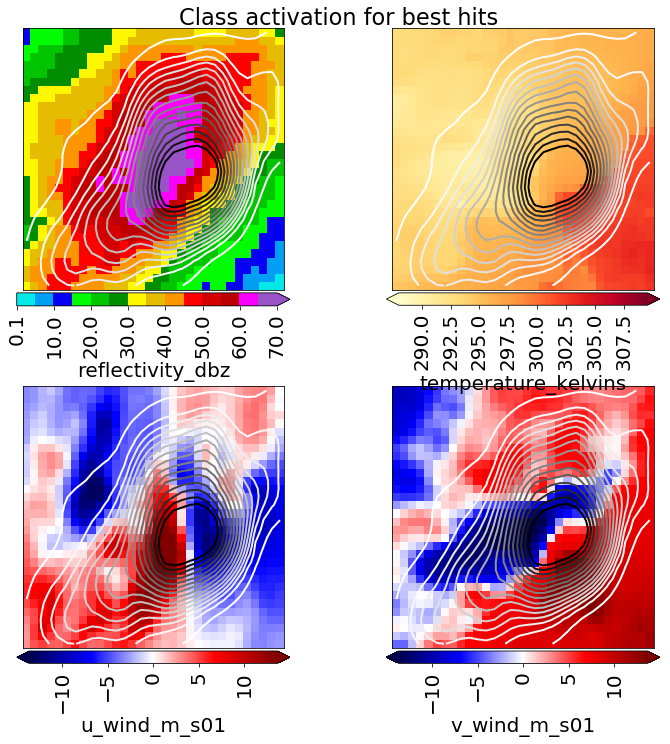

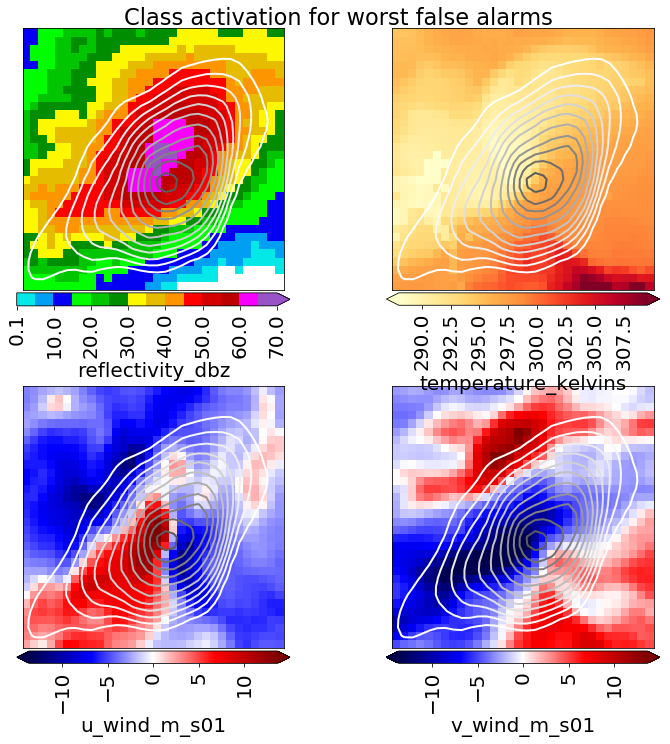

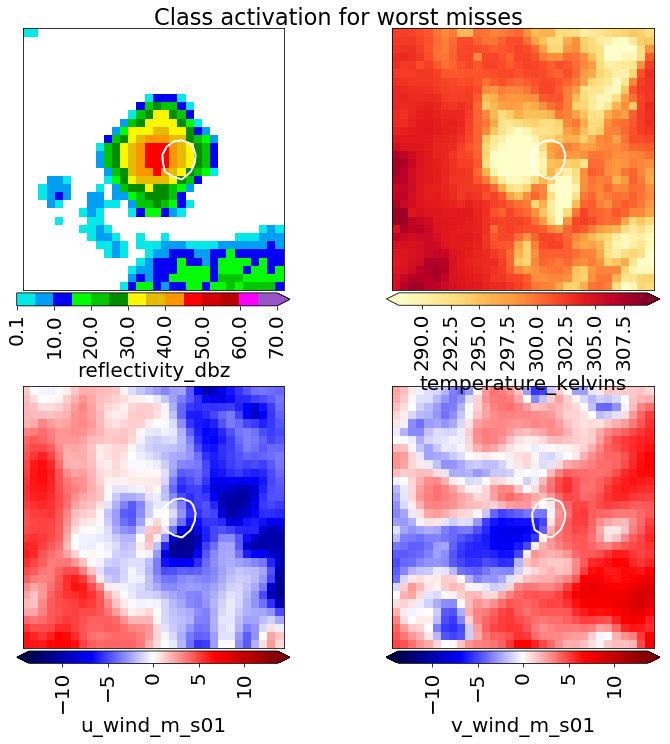

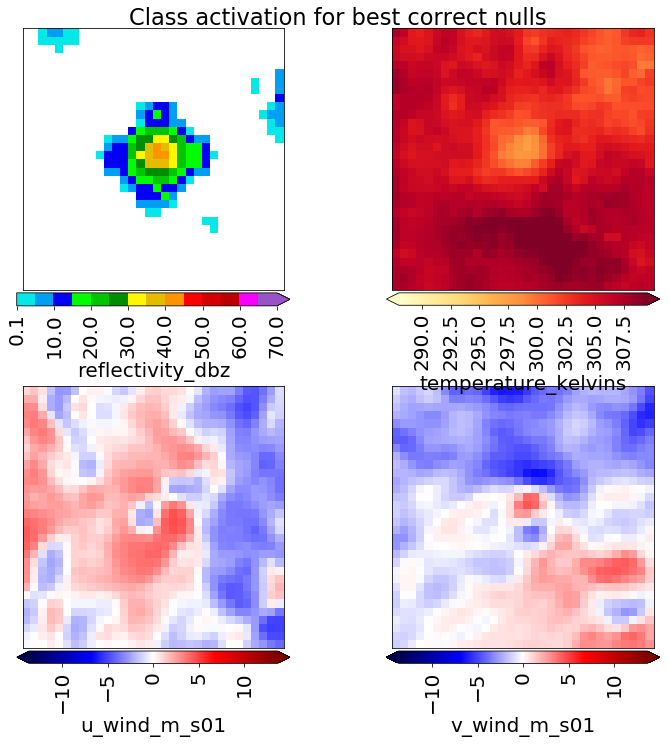

In [23]:
# num_examples_per_set = (
#     extreme_example_dict_norm[BEST_HIT_MATRIX_KEY].shape[0]
# )
num_examples_per_set = 10

best_hits_matrix_denorm = extreme_example_dict_denorm[
    BEST_HIT_MATRIX_KEY
][:num_examples_per_set, ...]

worst_fa_matrix_denorm = extreme_example_dict_denorm[
    WORST_FALSE_ALARM_MATRIX_KEY
][:num_examples_per_set, ...]

worst_misses_matrix_denorm = extreme_example_dict_denorm[
    WORST_MISS_MATRIX_KEY
][:num_examples_per_set, ...]

best_nulls_matrix_denorm = extreme_example_dict_denorm[
    BEST_CORRECT_NULLS_MATRIX_KEY
][:num_examples_per_set, ...]

best_hits_matrix_denorm_pmm = utils.run_pmm_many_variables(
    field_matrix=best_hits_matrix_denorm
)
worst_fa_matrix_denorm_pmm = utils.run_pmm_many_variables(
    field_matrix=worst_fa_matrix_denorm
)
worst_misses_matrix_denorm_pmm = utils.run_pmm_many_variables(
    field_matrix=worst_misses_matrix_denorm
)
best_nulls_matrix_denorm_pmm = utils.run_pmm_many_variables(
    field_matrix=best_nulls_matrix_denorm
)

these_dim = best_hits_matrix_denorm.shape[:-1]
best_hits_activn_matrix = numpy.full(these_dim, numpy.nan)
worst_fa_activn_matrix = numpy.full(these_dim, numpy.nan)
worst_misses_activn_matrix = numpy.full(these_dim, numpy.nan)
best_nulls_activn_matrix = numpy.full(these_dim, numpy.nan)

for i in range(num_examples_per_set):
    print('Have computed CAM for {0:d} of {1:d} extreme examples...'.format(
        4 * i, 4 * num_examples_per_set
    ))

    best_hits_activn_matrix[i, ...] = class_activation.run_gradcam(
        model_object=cnn_model_object,
        input_matrix=extreme_example_dict_norm[BEST_HIT_MATRIX_KEY][i, ...],
        target_class=1, target_layer_name='batch_normalization_3'
    )

    worst_fa_activn_matrix[i, ...] = class_activation.run_gradcam(
        model_object=cnn_model_object,
        input_matrix=
        extreme_example_dict_norm[WORST_FALSE_ALARM_MATRIX_KEY][i, ...],
        target_class=1, target_layer_name='batch_normalization_3'
    )

    worst_misses_activn_matrix[i, ...] = class_activation.run_gradcam(
        model_object=cnn_model_object,
        input_matrix=
        extreme_example_dict_norm[WORST_MISS_MATRIX_KEY][i, ...],
        target_class=1, target_layer_name='batch_normalization_3'
    )

    best_nulls_activn_matrix[i, ...] = class_activation.run_gradcam(
        model_object=cnn_model_object,
        input_matrix=
        extreme_example_dict_norm[BEST_CORRECT_NULLS_MATRIX_KEY][i, ...],
        target_class=1, target_layer_name='batch_normalization_3'
    )

print('Have computed CAM for all {0:d} extreme examples!'.format(
    4 * num_examples_per_set
))

best_hits_activn_matrix_pmm = utils.run_pmm_one_variable(
    field_matrix=best_hits_activn_matrix
)
worst_fa_activn_matrix_pmm = utils.run_pmm_one_variable(
    field_matrix=worst_fa_activn_matrix
)
worst_misses_activn_matrix_pmm = utils.run_pmm_one_variable(
    field_matrix=worst_misses_activn_matrix
)
best_nulls_activn_matrix_pmm = utils.run_pmm_one_variable(
    field_matrix=best_nulls_activn_matrix
)

concat_predictor_matrix = numpy.stack((
    best_hits_matrix_denorm_pmm, worst_fa_matrix_denorm_pmm,
    worst_misses_matrix_denorm_pmm, best_nulls_matrix_denorm_pmm,
), axis=0)

predictor_names = extreme_example_dict_denorm[PREDICTOR_NAMES_KEY]

temperature_matrix_kelvins = concat_predictor_matrix[
    ..., predictor_names.index(utils.TEMPERATURE_NAME)
]
min_temp_kelvins = numpy.percentile(temperature_matrix_kelvins, 1)
max_temp_kelvins = numpy.percentile(temperature_matrix_kelvins, 99)

wind_indices = numpy.array([
    predictor_names.index(utils.U_WIND_NAME),
    predictor_names.index(utils.V_WIND_NAME)
], dtype=int)

max_speed_m_s01 = numpy.percentile(
    numpy.absolute(concat_predictor_matrix[..., wind_indices]), 99
)

concat_activation_matrix = numpy.stack((
    best_hits_activn_matrix_pmm, worst_fa_activn_matrix_pmm,
    worst_misses_activn_matrix_pmm, best_nulls_activn_matrix_pmm,
), axis=0)

max_contour_value = numpy.percentile(concat_activation_matrix, 99)

figure_object, axes_object_matrix = (
    plotting.plot_many_predictors_sans_barbs(
        predictor_matrix=best_hits_matrix_denorm_pmm,
        predictor_names=predictor_names,
        min_colour_temp_kelvins=min_temp_kelvins,
        max_colour_temp_kelvins=max_temp_kelvins,
        max_colour_wind_speed_m_s01=max_speed_m_s01)
)

class_activation.plot_2d_cam(
    class_activation_matrix_2d=best_hits_activn_matrix_pmm,
    axes_object_matrix=axes_object_matrix,
    num_channels=len(predictor_names),
    colour_map_object=pyplot.get_cmap('Greys'),
    min_contour_value=max_contour_value / 15,
    max_contour_value=max_contour_value,
    contour_interval=max_contour_value / 15
)

figure_object.suptitle('Class activation for best hits')

figure_object, axes_object_matrix = (
    plotting.plot_many_predictors_sans_barbs(
        predictor_matrix=worst_fa_matrix_denorm_pmm,
        predictor_names=predictor_names,
        min_colour_temp_kelvins=min_temp_kelvins,
        max_colour_temp_kelvins=max_temp_kelvins,
        max_colour_wind_speed_m_s01=max_speed_m_s01)
)

class_activation.plot_2d_cam(
    class_activation_matrix_2d=worst_fa_activn_matrix_pmm,
    axes_object_matrix=axes_object_matrix,
    num_channels=len(predictor_names),
    colour_map_object=pyplot.get_cmap('Greys'),
    min_contour_value=max_contour_value / 15,
    max_contour_value=max_contour_value,
    contour_interval=max_contour_value / 15
)

figure_object.suptitle('Class activation for worst false alarms')

figure_object, axes_object_matrix = (
    plotting.plot_many_predictors_sans_barbs(
        predictor_matrix=worst_misses_matrix_denorm_pmm,
        predictor_names=predictor_names,
        min_colour_temp_kelvins=min_temp_kelvins,
        max_colour_temp_kelvins=max_temp_kelvins,
        max_colour_wind_speed_m_s01=max_speed_m_s01)
)

class_activation.plot_2d_cam(
    class_activation_matrix_2d=worst_misses_activn_matrix_pmm,
    axes_object_matrix=axes_object_matrix,
    num_channels=len(predictor_names),
    colour_map_object=pyplot.get_cmap('Greys'),
    min_contour_value=max_contour_value / 15,
    max_contour_value=max_contour_value,
    contour_interval=max_contour_value / 15
)

figure_object.suptitle('Class activation for worst misses')

figure_object, axes_object_matrix = (
    plotting.plot_many_predictors_sans_barbs(
        predictor_matrix=best_nulls_matrix_denorm_pmm,
        predictor_names=predictor_names,
        min_colour_temp_kelvins=min_temp_kelvins,
        max_colour_temp_kelvins=max_temp_kelvins,
        max_colour_wind_speed_m_s01=max_speed_m_s01)
)

class_activation.plot_2d_cam(
    class_activation_matrix_2d=best_nulls_activn_matrix_pmm,
    axes_object_matrix=axes_object_matrix,
    num_channels=len(predictor_names),
    colour_map_object=pyplot.get_cmap('Greys'),
    min_contour_value=max_contour_value / 15,
    max_contour_value=max_contour_value,
    contour_interval=max_contour_value / 15
)

figure_object.suptitle('Class activation for best correct nulls')

# Backwards Optimization: Example 1

Loss after 0 of 1000 iterations = 9.86e-01 ... activation = 7.04e-03
Loss after 100 of 1000 iterations = 9.86e-01 ... activation = 7.36e-03
Loss after 200 of 1000 iterations = 9.85e-01 ... activation = 7.86e-03
Loss after 300 of 1000 iterations = 9.84e-01 ... activation = 8.69e-03
Loss after 400 of 1000 iterations = 9.83e-01 ... activation = 1.01e-02
Loss after 500 of 1000 iterations = 9.80e-01 ... activation = 1.23e-02
Loss after 600 of 1000 iterations = 9.75e-01 ... activation = 1.61e-02
Loss after 700 of 1000 iterations = 9.66e-01 ... activation = 2.18e-02
Loss after 800 of 1000 iterations = 9.49e-01 ... activation = 3.18e-02
Loss after 900 of 1000 iterations = 9.20e-01 ... activation = 4.87e-02
Loss after 1000 iterations = 8.73e-01 ... activation = 7.57e-02


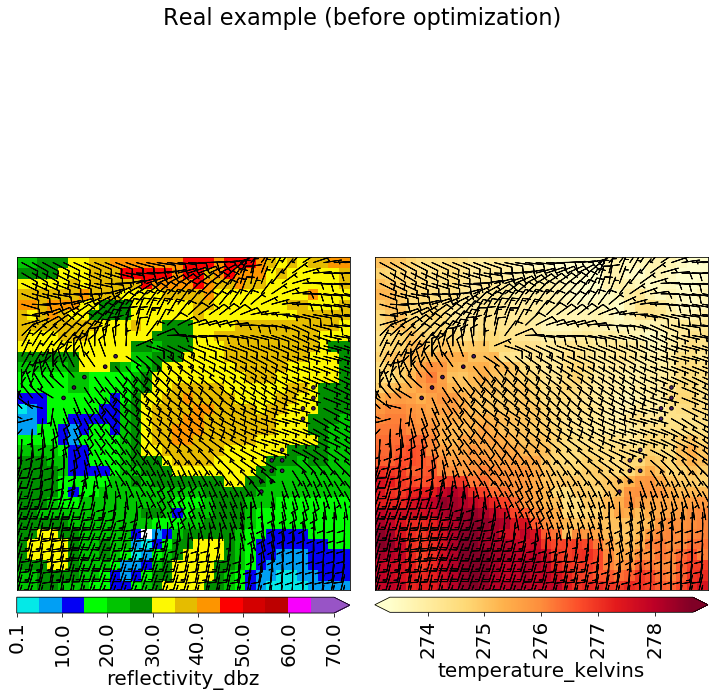

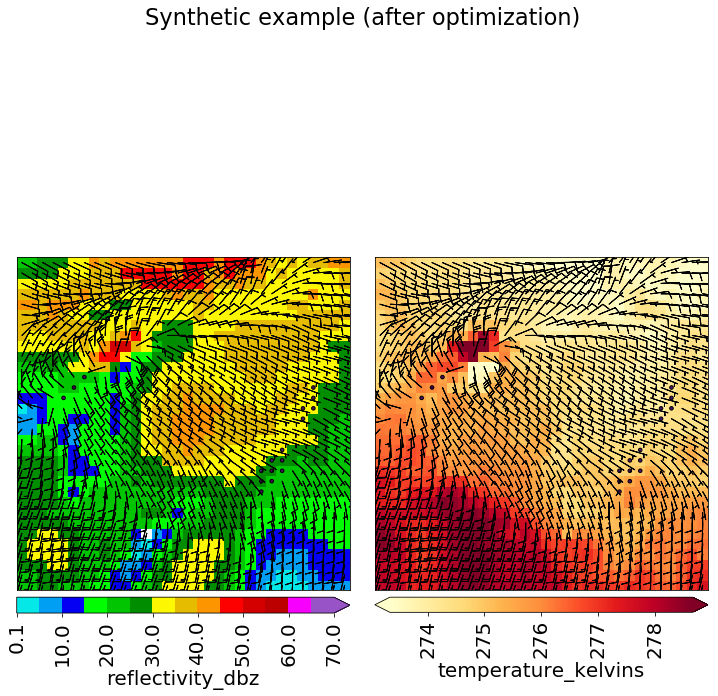

In [23]:
orig_predictor_matrix_denorm = (
    validation_image_dict[utils.PREDICTOR_MATRIX_KEY][0, ...] + 0.
)
predictor_names = validation_image_dict[utils.PREDICTOR_NAMES_KEY]

orig_predictor_matrix_norm, _ = normalization.normalize_images(
    predictor_matrix=orig_predictor_matrix_denorm + 0.,
    predictor_names=predictor_names,
    normalization_dict=normalization_dict
)
orig_predictor_matrix_norm = numpy.expand_dims(
    orig_predictor_matrix_norm, axis=0
)

new_predictor_matrix_norm = backwards_opt.optimize_example_for_class(
    model_object=cnn_model_object, input_matrix=orig_predictor_matrix_norm,
    target_class=1, num_iterations=1000, learning_rate=0.0001,
    l2_weight=0.0005
)[0][0, ...]

new_predictor_matrix_denorm = normalization.denormalize_images(
    predictor_matrix=new_predictor_matrix_norm,
    predictor_names=predictor_names,
    normalization_dict=normalization_dict
)

temperature_index = predictor_names.index(utils.TEMPERATURE_NAME)
combined_temp_matrix_kelvins = numpy.concatenate((
    orig_predictor_matrix_denorm[..., temperature_index],
    new_predictor_matrix_denorm[..., temperature_index]
), axis=0)

min_temp_kelvins = numpy.percentile(combined_temp_matrix_kelvins, 1)
max_temp_kelvins = numpy.percentile(combined_temp_matrix_kelvins, 99)

figure_object, _ = plotting.plot_many_predictors_with_barbs(
    predictor_matrix=orig_predictor_matrix_denorm,
    predictor_names=predictor_names,
    min_colour_temp_kelvins=min_temp_kelvins,
    max_colour_temp_kelvins=max_temp_kelvins
)

figure_object.suptitle('Real example (before optimization)')
pyplot.show()

figure_object, _ = plotting.plot_many_predictors_with_barbs(
    predictor_matrix=new_predictor_matrix_denorm,
    predictor_names=predictor_names,
    min_colour_temp_kelvins=min_temp_kelvins,
    max_colour_temp_kelvins=max_temp_kelvins
)

figure_object.suptitle('Synthetic example (after optimization)')
pyplot.show()

# Backwards Optimization: Example 2

Loss after 0 of 1000 iterations = 4.96e-05 ... activation = 7.04e-03
Loss after 100 of 1000 iterations = 4.69e-05 ... activation = 6.85e-03
Loss after 200 of 1000 iterations = 4.51e-05 ... activation = 6.72e-03
Loss after 300 of 1000 iterations = 4.38e-05 ... activation = 6.62e-03
Loss after 400 of 1000 iterations = 4.27e-05 ... activation = 6.53e-03
Loss after 500 of 1000 iterations = 4.18e-05 ... activation = 6.47e-03
Loss after 600 of 1000 iterations = 4.11e-05 ... activation = 6.41e-03
Loss after 700 of 1000 iterations = 4.04e-05 ... activation = 6.36e-03
Loss after 800 of 1000 iterations = 3.99e-05 ... activation = 6.31e-03
Loss after 900 of 1000 iterations = 3.93e-05 ... activation = 6.27e-03
Loss after 1000 iterations = 3.88e-05 ... activation = 6.23e-03


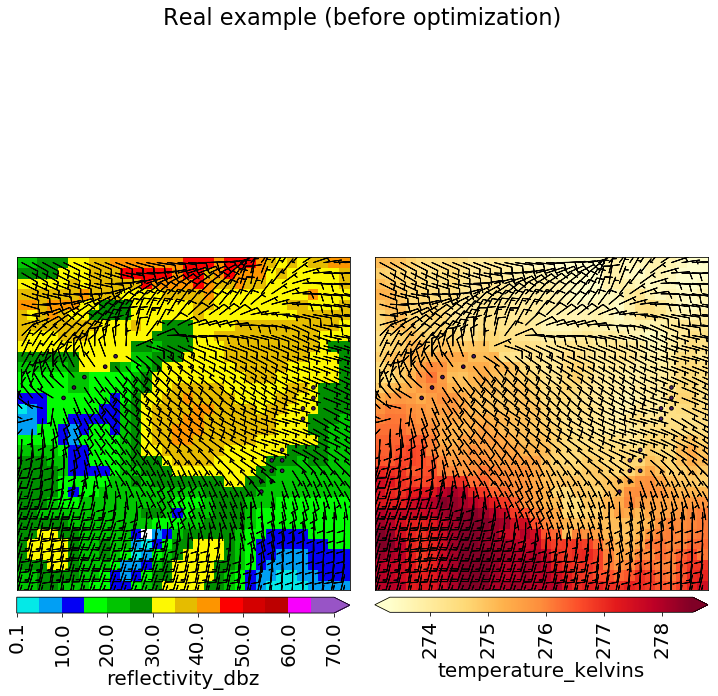

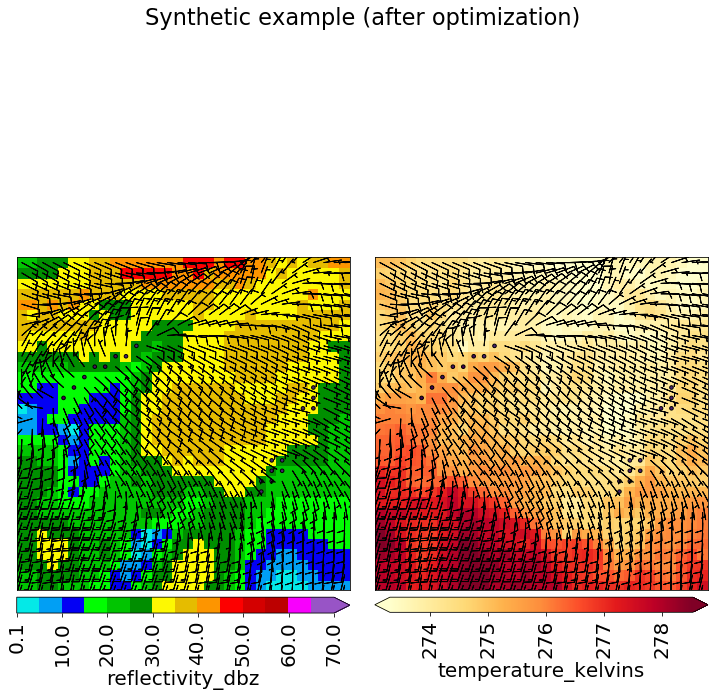

In [26]:
orig_predictor_matrix_denorm = (
    validation_image_dict[utils.PREDICTOR_MATRIX_KEY][0, ...] + 0.
)
predictor_names = validation_image_dict[utils.PREDICTOR_NAMES_KEY]

orig_predictor_matrix_norm, _ = normalization.normalize_images(
    predictor_matrix=orig_predictor_matrix_denorm + 0.,
    predictor_names=predictor_names,
    normalization_dict=normalization_dict
)
orig_predictor_matrix_norm = numpy.expand_dims(
    orig_predictor_matrix_norm, axis=0
)

new_predictor_matrix_norm = backwards_opt.optimize_example_for_class(
    model_object=cnn_model_object, input_matrix=orig_predictor_matrix_norm,
    target_class=0, num_iterations=1000, learning_rate=0.0001,
    l2_weight=0.
)[0][0, ...]

new_predictor_matrix_denorm = normalization.denormalize_images(
    predictor_matrix=new_predictor_matrix_norm,
    predictor_names=predictor_names,
    normalization_dict=normalization_dict
)

temperature_index = predictor_names.index(utils.TEMPERATURE_NAME)
combined_temp_matrix_kelvins = numpy.concatenate((
    orig_predictor_matrix_denorm[..., temperature_index],
    new_predictor_matrix_denorm[..., temperature_index]
), axis=0)

min_temp_kelvins = numpy.percentile(combined_temp_matrix_kelvins, 1)
max_temp_kelvins = numpy.percentile(combined_temp_matrix_kelvins, 99)

figure_object, _ = plotting.plot_many_predictors_with_barbs(
    predictor_matrix=orig_predictor_matrix_denorm,
    predictor_names=predictor_names,
    min_colour_temp_kelvins=min_temp_kelvins,
    max_colour_temp_kelvins=max_temp_kelvins
)

figure_object.suptitle('Real example (before optimization)')
pyplot.show()

figure_object, _ = plotting.plot_many_predictors_with_barbs(
    predictor_matrix=new_predictor_matrix_denorm,
    predictor_names=predictor_names,
    min_colour_temp_kelvins=min_temp_kelvins,
    max_colour_temp_kelvins=max_temp_kelvins
)

figure_object.suptitle('Synthetic example (after optimization)')
pyplot.show()

# Backwards Optimization: Example 3

Loss after 0 of 1000 iterations = 1.00e+00 ... activation = 1.00e+00
Loss after 100 of 1000 iterations = 9.91e-01 ... activation = 9.95e-01
Loss after 200 of 1000 iterations = 4.55e-01 ... activation = 6.75e-01
Loss after 300 of 1000 iterations = 4.26e-02 ... activation = 2.06e-01
Loss after 400 of 1000 iterations = 1.85e-02 ... activation = 1.36e-01
Loss after 500 of 1000 iterations = 3.97e-03 ... activation = 6.30e-02
Loss after 600 of 1000 iterations = 5.42e-04 ... activation = 2.33e-02
Loss after 700 of 1000 iterations = 2.09e-04 ... activation = 1.45e-02
Loss after 800 of 1000 iterations = 1.34e-04 ... activation = 1.16e-02
Loss after 900 of 1000 iterations = 9.86e-05 ... activation = 9.93e-03
Loss after 1000 iterations = 6.52e-05 ... activation = 8.07e-03


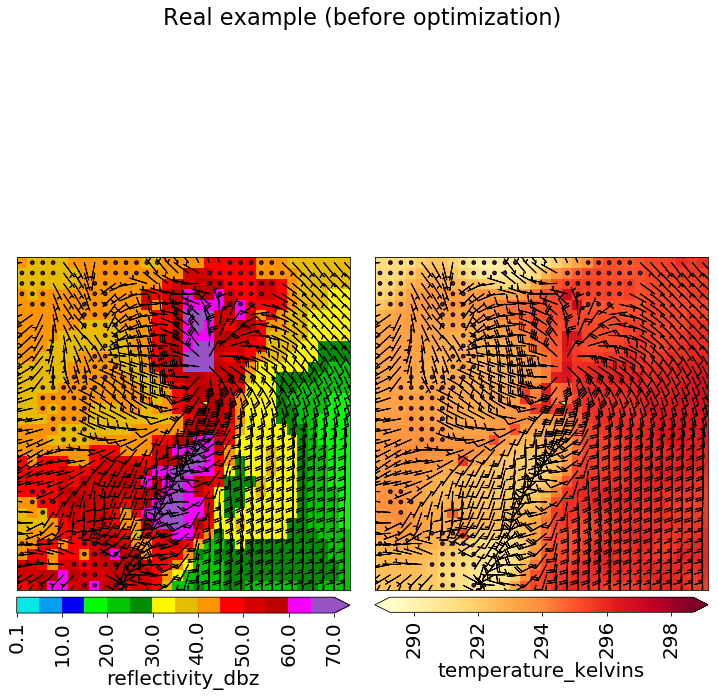

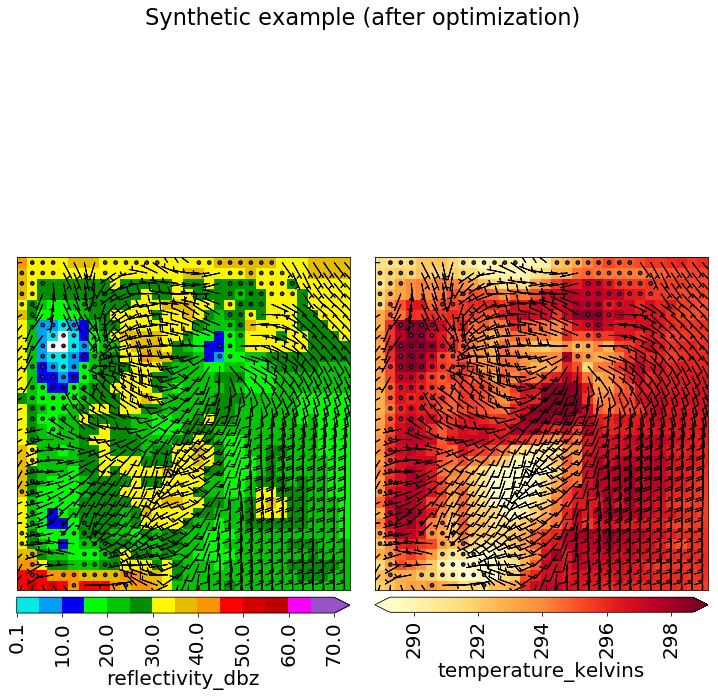

In [35]:
target_matrix_s01 = validation_image_dict[utils.TARGET_MATRIX_KEY]
example_index = numpy.unravel_index(
    numpy.argmax(target_matrix_s01), target_matrix_s01.shape
)[0]

orig_predictor_matrix_denorm = (
    validation_image_dict[utils.PREDICTOR_MATRIX_KEY][example_index, ...]
    + 0.
)
predictor_names = validation_image_dict[utils.PREDICTOR_NAMES_KEY]

orig_predictor_matrix_norm, _ = normalization.normalize_images(
    predictor_matrix=orig_predictor_matrix_denorm + 0.,
    predictor_names=predictor_names,
    normalization_dict=normalization_dict
)
orig_predictor_matrix_norm = numpy.expand_dims(
    orig_predictor_matrix_norm, axis=0
)

new_predictor_matrix_norm = backwards_opt.optimize_example_for_class(
    model_object=cnn_model_object, input_matrix=orig_predictor_matrix_norm,
    target_class=0, num_iterations=1000, learning_rate=0.001,
    l2_weight=0.
)[0][0, ...]

new_predictor_matrix_denorm = normalization.denormalize_images(
    predictor_matrix=new_predictor_matrix_norm,
    predictor_names=predictor_names,
    normalization_dict=normalization_dict
)

temperature_index = predictor_names.index(utils.TEMPERATURE_NAME)
combined_temp_matrix_kelvins = numpy.concatenate((
    orig_predictor_matrix_denorm[..., temperature_index],
    new_predictor_matrix_denorm[..., temperature_index]
), axis=0)

min_temp_kelvins = numpy.percentile(combined_temp_matrix_kelvins, 1)
max_temp_kelvins = numpy.percentile(combined_temp_matrix_kelvins, 99)

figure_object, _ = plotting.plot_many_predictors_with_barbs(
    predictor_matrix=orig_predictor_matrix_denorm,
    predictor_names=predictor_names,
    min_colour_temp_kelvins=min_temp_kelvins,
    max_colour_temp_kelvins=max_temp_kelvins
)

figure_object.suptitle('Real example (before optimization)')
pyplot.show()

figure_object, _ = plotting.plot_many_predictors_with_barbs(
    predictor_matrix=new_predictor_matrix_denorm,
    predictor_names=predictor_names,
    min_colour_temp_kelvins=min_temp_kelvins,
    max_colour_temp_kelvins=max_temp_kelvins
)

figure_object.suptitle('Synthetic example (after optimization)')
pyplot.show()

# Backwards Optimization: Example 4

Loss after 0 of 1000 iterations = 1.00e+00 ... activation = 1.00e+00
Loss after 100 of 1000 iterations = 1.00e+00 ... activation = 1.00e+00
Loss after 200 of 1000 iterations = 1.00e+00 ... activation = 1.00e+00
Loss after 300 of 1000 iterations = 9.98e-01 ... activation = 9.99e-01
Loss after 400 of 1000 iterations = 9.92e-01 ... activation = 9.95e-01
Loss after 500 of 1000 iterations = 9.67e-01 ... activation = 9.83e-01
Loss after 600 of 1000 iterations = 8.93e-01 ... activation = 9.44e-01
Loss after 700 of 1000 iterations = 7.22e-01 ... activation = 8.48e-01
Loss after 800 of 1000 iterations = 4.58e-01 ... activation = 6.74e-01
Loss after 900 of 1000 iterations = 2.32e-01 ... activation = 4.77e-01
Loss after 1000 iterations = 1.26e-01 ... activation = 3.47e-01


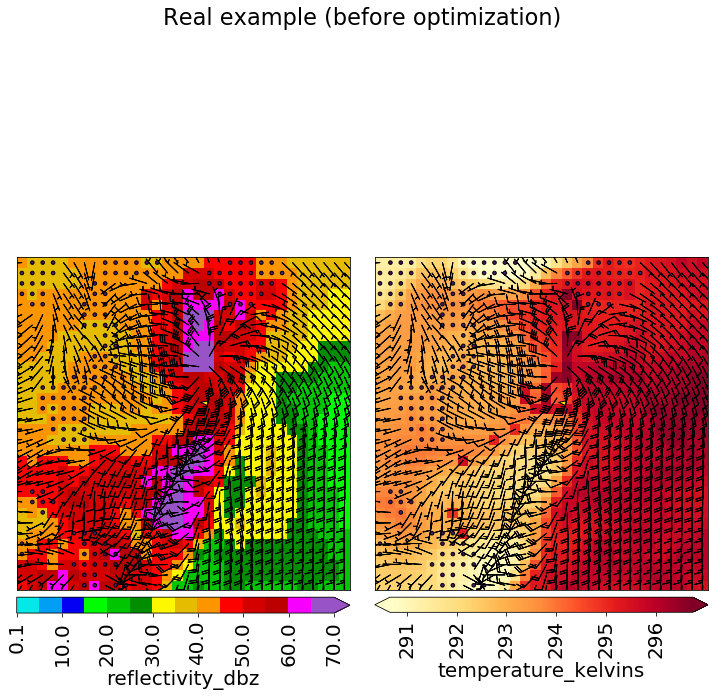

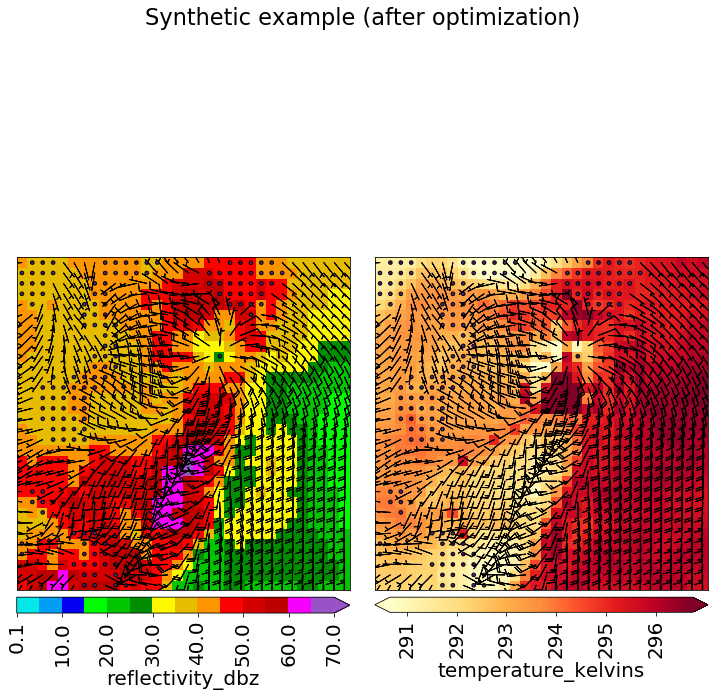

In [43]:
target_matrix_s01 = validation_image_dict[utils.TARGET_MATRIX_KEY]
example_index = numpy.unravel_index(
    numpy.argmax(target_matrix_s01), target_matrix_s01.shape
)[0]

orig_predictor_matrix_denorm = (
    validation_image_dict[utils.PREDICTOR_MATRIX_KEY][example_index, ...]
    + 0.
)
predictor_names = validation_image_dict[utils.PREDICTOR_NAMES_KEY]

orig_predictor_matrix_norm, _ = normalization.normalize_images(
    predictor_matrix=orig_predictor_matrix_denorm + 0.,
    predictor_names=predictor_names,
    normalization_dict=normalization_dict
)
orig_predictor_matrix_norm = numpy.expand_dims(
    orig_predictor_matrix_norm, axis=0
)

new_predictor_matrix_norm = backwards_opt.optimize_example_for_class(
    model_object=cnn_model_object, input_matrix=orig_predictor_matrix_norm,
    target_class=0, num_iterations=1000, learning_rate=2.5e-4,
    l2_weight=2.5e-5
)[0][0, ...]

new_predictor_matrix_denorm = normalization.denormalize_images(
    predictor_matrix=new_predictor_matrix_norm,
    predictor_names=predictor_names,
    normalization_dict=normalization_dict
)

temperature_index = predictor_names.index(utils.TEMPERATURE_NAME)
combined_temp_matrix_kelvins = numpy.concatenate((
    orig_predictor_matrix_denorm[..., temperature_index],
    new_predictor_matrix_denorm[..., temperature_index]
), axis=0)

min_temp_kelvins = numpy.percentile(combined_temp_matrix_kelvins, 1)
max_temp_kelvins = numpy.percentile(combined_temp_matrix_kelvins, 99)

figure_object, _ = plotting.plot_many_predictors_with_barbs(
    predictor_matrix=orig_predictor_matrix_denorm,
    predictor_names=predictor_names,
    min_colour_temp_kelvins=min_temp_kelvins,
    max_colour_temp_kelvins=max_temp_kelvins
)

figure_object.suptitle('Real example (before optimization)')
pyplot.show()

figure_object, _ = plotting.plot_many_predictors_with_barbs(
    predictor_matrix=new_predictor_matrix_denorm,
    predictor_names=predictor_names,
    min_colour_temp_kelvins=min_temp_kelvins,
    max_colour_temp_kelvins=max_temp_kelvins
)

figure_object.suptitle('Synthetic example (after optimization)')
pyplot.show()

# Upconvnets

Upconvnets (upconvolutional networks) are basically the inverse of a CNN (convolutional network).  The goal of a CNN is to minimize the loss function (*e.g.*, cross-entropy) for a prediction task.  During this process, the CNN runs convolutional filters over the input images (*e.g.*, model grids of reflectivity, temperature, $u$-wind, and $v$-wind).  This is achieved by a stack of convolutional layers (shown below), which are followed by a stack of dense layers (or "fully connected" layers &ndash; the kind that occur in a traditional neural net).

<img src="cnn_architecture.jpg" alt="CNN architecture" width="1000" />

Between the convolutional and dense layers, there is a flattening layer, which collapses feature maps learned by the convolutional filters into a 1-D vector.  The numbers in this vector are called "scalar features," because they are no longer in a spatial grid.

The goal of an upconvnet is to transform these scalar features back into the original images (*e.g.*, model grids of reflectivity, temperature, $u$-wind, and $v$-wind).

We will use upconvnets for the next interpretation method (novelty detection).

# Upconvnet Setup

The next cell defines methods for setting up (but not training) an upconvnet.  As for the CNN, "setting up" means defining the architecture, loss function, and optimizer.  The architecture for the upconvnet is basically the CNN architecture backwards.  The loss function for the upconvnet is pixelwise MSE (mean squared error) between the original and reconstructed images.  The optimizer for the upconvnet is Adam, as for the CNN.

In [ ]:
def _create_smoothing_filter(
        smoothing_radius_px, num_half_filter_rows, num_half_filter_columns,
        num_channels):
    """Creates convolution filter for Gaussian smoothing.

    M = number of rows in filter
    N = number of columns in filter
    C = number of channels (or "variables" or "features") to smooth.  Each
        channel will be smoothed independently.

    :param smoothing_radius_px: e-folding radius (pixels).
    :param num_half_filter_rows: Number of rows in one half of filter.  Total
        number of rows will be 2 * `num_half_filter_rows` + 1.
    :param num_half_filter_columns: Same but for columns.
    :param num_channels: C in the above discussion.
    :return: weight_matrix: M-by-N-by-C-by-C numpy array of convolution weights.
    """

    num_filter_rows = 2 * num_half_filter_rows + 1
    num_filter_columns = 2 * num_half_filter_columns + 1

    row_offsets_unique = numpy.linspace(
        -num_half_filter_rows, num_half_filter_rows, num=num_filter_rows,
        dtype=float)
    column_offsets_unique = numpy.linspace(
        -num_half_filter_columns, num_half_filter_columns,
        num=num_filter_columns, dtype=float)

    column_offset_matrix, row_offset_matrix = numpy.meshgrid(
        column_offsets_unique, row_offsets_unique)

    pixel_offset_matrix = numpy.sqrt(
        row_offset_matrix ** 2 + column_offset_matrix ** 2)

    small_weight_matrix = numpy.exp(
        -pixel_offset_matrix ** 2 / (2 * smoothing_radius_px ** 2)
    )
    small_weight_matrix = small_weight_matrix / numpy.sum(small_weight_matrix)

    weight_matrix = numpy.zeros(
        (num_filter_rows, num_filter_columns, num_channels, num_channels)
    )

    for k in range(num_channels):
        weight_matrix[..., k, k] = small_weight_matrix

    return weight_matrix


def setup_ucn(
        num_input_features, first_num_rows, first_num_columns,
        upsampling_factors, num_output_channels,
        use_activation_for_out_layer=False, use_bn_for_out_layer=True,
        use_transposed_conv=False, smoothing_radius_px=None):
    """Creates (but does not train) upconvnet.

    L = number of conv or deconv layers

    :param num_input_features: Number of input features.
    :param first_num_rows: Number of rows in input to first deconv layer.  The
        input features will be reshaped into a grid with this many rows.
    :param first_num_columns: Same but for columns.
    :param upsampling_factors: length-L numpy array of upsampling factors.  Must
        all be positive integers.
    :param num_output_channels: Number of channels in output images.
    :param use_activation_for_out_layer: Boolean flag.  If True, activation will
        be applied to output layer.
    :param use_bn_for_out_layer: Boolean flag.  If True, batch normalization
        will be applied to output layer.
    :param use_transposed_conv: Boolean flag.  If True, upsampling will be done
        with transposed-convolution layers.  If False, each upsampling will be
        done with an upsampling layer followed by a conv layer.
    :param smoothing_radius_px: Smoothing radius (pixels).  Gaussian smoothing
        with this e-folding radius will be done after each upsampling.  If
        `smoothing_radius_px is None`, no smoothing will be done.
    :return: ucn_model_object: Untrained instance of `keras.models.Model`.
    """

    if smoothing_radius_px is not None:
        num_half_smoothing_rows = int(numpy.round(
            (NUM_SMOOTHING_FILTER_ROWS - 1) / 2
        ))
        num_half_smoothing_columns = int(numpy.round(
            (NUM_SMOOTHING_FILTER_COLUMNS - 1) / 2
        ))

    regularizer_object = keras.regularizers.l1_l2(l1=L1_WEIGHT, l2=L2_WEIGHT)
    input_layer_object = keras.layers.Input(shape=(num_input_features,))

    current_num_filters = int(numpy.round(
        num_input_features / (first_num_rows * first_num_columns)
    ))

    layer_object = keras.layers.Reshape(
        target_shape=(first_num_rows, first_num_columns, current_num_filters)
    )(input_layer_object)

    num_main_layers = len(upsampling_factors)

    for i in range(num_main_layers):
        this_upsampling_factor = upsampling_factors[i]

        if i == num_main_layers - 1:
            current_num_filters = num_output_channels + 0
        elif this_upsampling_factor == 1:
            current_num_filters = int(numpy.round(current_num_filters / 2))

        if use_transposed_conv:
            if this_upsampling_factor > 1:
                this_padding_arg = 'same'
            else:
                this_padding_arg = 'valid'

            layer_object = keras.layers.Conv2DTranspose(
                filters=current_num_filters,
                kernel_size=(NUM_CONV_FILTER_ROWS, NUM_CONV_FILTER_COLUMNS),
                strides=(this_upsampling_factor, this_upsampling_factor),
                padding=this_padding_arg, data_format='channels_last',
                dilation_rate=(1, 1), activation=None, use_bias=True,
                kernel_initializer='glorot_uniform', bias_initializer='zeros',
                kernel_regularizer=regularizer_object
            )(layer_object)

        else:
            if this_upsampling_factor > 1:
                try:
                    layer_object = keras.layers.UpSampling2D(
                        size=(this_upsampling_factor, this_upsampling_factor),
                        data_format='channels_last', interpolation='nearest'
                    )(layer_object)
                except:
                    layer_object = keras.layers.UpSampling2D(
                        size=(this_upsampling_factor, this_upsampling_factor),
                        data_format='channels_last'
                    )(layer_object)

            layer_object = keras.layers.Conv2D(
                filters=current_num_filters,
                kernel_size=(NUM_CONV_FILTER_ROWS, NUM_CONV_FILTER_COLUMNS),
                strides=(1, 1), padding='same', data_format='channels_last',
                dilation_rate=(1, 1), activation=None, use_bias=True,
                kernel_initializer='glorot_uniform', bias_initializer='zeros',
                kernel_regularizer=regularizer_object
            )(layer_object)

            if this_upsampling_factor == 1:
                layer_object = keras.layers.ZeroPadding2D(
                    padding=(1, 1), data_format='channels_last'
                )(layer_object)

        if smoothing_radius_px is not None:
            this_weight_matrix = _create_smoothing_filter(
                smoothing_radius_px=smoothing_radius_px,
                num_half_filter_rows=num_half_smoothing_rows,
                num_half_filter_columns=num_half_smoothing_columns,
                num_channels=current_num_filters)

            this_bias_vector = numpy.zeros(current_num_filters)

            layer_object = keras.layers.Conv2D(
                filters=current_num_filters,
                kernel_size=(NUM_SMOOTHING_FILTER_ROWS,
                             NUM_SMOOTHING_FILTER_COLUMNS),
                strides=(1, 1), padding='same', data_format='channels_last',
                dilation_rate=(1, 1), activation=None, use_bias=True,
                kernel_initializer='glorot_uniform', bias_initializer='zeros',
                kernel_regularizer=regularizer_object, trainable=False,
                weights=[this_weight_matrix, this_bias_vector]
            )(layer_object)

        if i < num_main_layers - 1 or use_activation_for_out_layer:
            layer_object = keras.layers.LeakyReLU(
                alpha=SLOPE_FOR_RELU
            )(layer_object)

        if i < num_main_layers - 1 or use_bn_for_out_layer:
            layer_object = keras.layers.BatchNormalization(
                axis=-1, center=True, scale=True
            )(layer_object)

    ucn_model_object = keras.models.Model(
        inputs=input_layer_object, outputs=layer_object)
    ucn_model_object.compile(
        loss=keras.losses.mean_squared_error, optimizer=keras.optimizers.Adam())

    ucn_model_object.summary()
    return ucn_model_object

# Upconvnet Setup: Example

The next cell runs `setup_ucn`, which prints the architecture in a plain-text table.  The architecture is explained below.

 - The input is a length-6400 vector (preferably created by the flattening layer of the CNN).
 - The "reshaping" layer changes the dimensions to $5 \times 5 \times 256$.
 - The first transposed convolution (or "deconvolution" or "upconvolution") changes the dimensions to $10 \times 10 \times 256$ (10 rows, 10 columns, and 256 filters).
 - The next transposed convolution changes the dimensions to $12 \times 12 \times 128$.  In general, as data are passed through the upconvnet, the spatial dimensions grow and the number of filters shrinks &ndash; the opposite of what happens in a CNN.
 - The next transposed convolution changes the dimensions to $14 \times 14 \times 64$.
 - The next transposed convolution changes the dimensions to $28 \times 28 \times 64$.
 - The next transposed convolution changes the dimensions to $30 \times 30 \times 32$.
 - The final transposed convolution changes the dimensions to $32 \times 32 \times 4$ (same as the original model grids).
 
The loss function is pixelwise mean squared error, defined below.

$\textrm{MSE} = \frac{1}{N} \frac{1}{32} \frac{1}{32} \frac{1}{4} (\hat{y}_{i, j, k, m} - y_{i, j, k, m})^2$

$N$ is the number of examples in the batch; $y_{i, j, k, m}$ is the actual value (in the original image) of the $m^{\textrm{th}}$ predictors in the $j^{\textrm{th}}$ row and $k^{\textrm{th}}$ column of the $i^{\textrm{th}}$ example; and $\hat{y}_{i, j, k, m}$ is the corresponding predicted value (in the reconstructed image).

For each **batch** of training examples, MSE is computed and all weights in the upconvnet &ndash; most of which reside in the transposed-convolution layers &ndash; are adjusted slightly in a way that reduces MSE.

In [ ]:
def get_cnn_flatten_layer(cnn_model_object):
    """Finds flattening layer in CNN.

    This method assumes that there is only one flattening layer.  If there are
    several, this method will return the first (shallowest).

    :param cnn_model_object: Instance of `keras.models.Model`.
    :return: layer_name: Name of flattening layer.
    :raises: TypeError: if flattening layer cannot be found.
    """

    layer_names = [lyr.name for lyr in cnn_model_object.layers]

    flattening_flags = numpy.array(
        ['flatten' in n for n in layer_names], dtype=bool)
    flattening_indices = numpy.where(flattening_flags)[0]

    if len(flattening_indices) == 0:
        error_string = (
            'Cannot find flattening layer in model.  Layer names are listed '
            'below.\n{0:s}'
        ).format(str(layer_names))

        raise TypeError(error_string)

    return layer_names[flattening_indices[0]]


cnn_feature_layer_name = get_cnn_flatten_layer(cnn_model_object)
cnn_feature_layer_object = cnn_model_object.get_layer(
    name=cnn_feature_layer_name)
cnn_feature_dimensions = numpy.array(
    cnn_feature_layer_object.input.shape[1:], dtype=int)

num_input_features = numpy.prod(cnn_feature_dimensions)
first_num_rows = cnn_feature_dimensions[0]
first_num_columns = cnn_feature_dimensions[1]
num_output_channels = numpy.array(
    cnn_model_object.input.shape[1:], dtype=int
)[-1]

upsampling_factors = numpy.array([2, 1, 1, 2, 1, 1], dtype=int)

ucn_model_object = setup_ucn(
    num_input_features=num_input_features, first_num_rows=first_num_rows,
    first_num_columns=first_num_columns,
    upsampling_factors=upsampling_factors,
    num_output_channels=num_output_channels,
    use_transposed_conv=True, smoothing_radius_px=None)

# Upconvnet Generator

The next cell defines the generator for the upconvnet.  This is very similar to the generator for the CNN.  The main difference is that the upconvnet generator uses a pre-trained CNN to convert the model grids (with dimensions $32 \times 32 \times 4$) to scalar features (a length-6400 vector, which is the input to the upconvnet).

In [ ]:
def ucn_generator(netcdf_file_names, num_examples_per_batch, normalization_dict,
                  cnn_model_object, cnn_feature_layer_name):
    """Generates training examples for UCN (upconvolutional network) on the fly.

    E = number of examples (storm objects)
    M = number of rows in each storm-centered grid
    N = number of columns in each storm-centered grid
    C = number of channels (predictor variables)
    Z = number of scalar features (neurons in layer `cnn_feature_layer_name` of
        the CNN specified by `cnn_model_object`)

    :param netcdf_file_names: 1-D list of paths to input (NetCDF) files.
    :param num_examples_per_batch: Number of examples per training batch.
    :param normalization_dict: See doc for `normalize_images`.  You cannot leave
        this as None.
    :param cnn_model_object: Trained CNN model (instance of
        `keras.models.Model`).  This will be used to turn images stored in
        `netcdf_file_names` into scalar features.
    :param cnn_feature_layer_name: The "scalar features" will be the set of
        activations from this layer.
    :return: feature_matrix: E-by-Z numpy array of scalar features.  These are
        the "predictors" for the upconv network.
    :return: target_matrix: E-by-M-by-N-by-C numpy array of target images.
        These are the predictors for the CNN and the targets for the upconv
        network.
    :raises: TypeError: if `normalization_dict is None`.
    """

    if normalization_dict is None:
        error_string = 'normalization_dict cannot be None.  Must be specified.'
        raise TypeError(error_string)

    random.shuffle(netcdf_file_names)
    num_files = len(netcdf_file_names)
    file_index = 0

    num_examples_in_memory = 0
    full_target_matrix = None
    predictor_names = None

    while True:
        while num_examples_in_memory < num_examples_per_batch:
            print('Reading data from: "{0:s}"...'.format(
                netcdf_file_names[file_index]))

            this_image_dict = read_image_file(netcdf_file_names[file_index])
            predictor_names = this_image_dict[PREDICTOR_NAMES_KEY]

            file_index += 1
            if file_index >= num_files:
                file_index = 0

            if full_target_matrix is None or full_target_matrix.size == 0:
                full_target_matrix = this_image_dict[PREDICTOR_MATRIX_KEY] + 0.
            else:
                full_target_matrix = numpy.concatenate(
                    (full_target_matrix, this_image_dict[PREDICTOR_MATRIX_KEY]),
                    axis=0)

            num_examples_in_memory = full_target_matrix.shape[0]

        batch_indices = numpy.linspace(
            0, num_examples_in_memory - 1, num=num_examples_in_memory,
            dtype=int)
        batch_indices = numpy.random.choice(
            batch_indices, size=num_examples_per_batch, replace=False)

        target_matrix, _ = normalize_images(
            predictor_matrix=full_target_matrix[batch_indices, ...],
            predictor_names=predictor_names,
            normalization_dict=normalization_dict)
        target_matrix = target_matrix.astype('float32')

        feature_matrix = _apply_cnn(
            cnn_model_object=cnn_model_object, predictor_matrix=target_matrix,
            verbose=False, output_layer_name=cnn_feature_layer_name)

        num_examples_in_memory = 0
        full_target_matrix = None

        yield (feature_matrix, target_matrix)

# Training the Upconvnet

The next cell defines a method to train the upconvnet.

In [ ]:
def train_ucn(
        ucn_model_object, training_file_names, normalization_dict,
        cnn_model_object, cnn_file_name, cnn_feature_layer_name,
        num_examples_per_batch, num_epochs, num_training_batches_per_epoch,
        output_model_file_name, validation_file_names=None,
        num_validation_batches_per_epoch=None):
    """Trains UCN (upconvolutional network).

    :param ucn_model_object: Untrained instance of `keras.models.Model` (may be
        created by `setup_ucn`), representing the upconv network.
    :param training_file_names: 1-D list of paths to training files (must be
        readable by `read_image_file`).
    :param normalization_dict: See doc for `ucn_generator`.
    :param cnn_model_object: Same.
    :param cnn_file_name: Path to file with trained CNN (represented by
        `cnn_model_object`).  This is needed only for the output dictionary
        (metadata).
    :param cnn_feature_layer_name: Same.
    :param num_examples_per_batch: Same.
    :param num_epochs: Number of epochs.
    :param num_training_batches_per_epoch: Number of training batches furnished
        to model in each epoch.
    :param output_model_file_name: Path to output file.  The model will be saved
        as an HDF5 file (extension should be ".h5", but this is not enforced).
    :param validation_file_names: 1-D list of paths to training files (must be
        readable by `read_image_file`).  If `validation_file_names is None`,
        will omit on-the-fly validation.
    :param num_validation_batches_per_epoch:
        [used only if `validation_file_names is not None`]
        Number of validation batches furnished to model in each epoch.

    :return: ucn_metadata_dict: Dictionary with the following keys.
    ucn_metadata_dict['training_file_names']: See input doc.
    ucn_metadata_dict['normalization_dict']: Same.
    ucn_metadata_dict['cnn_file_name']: Same.
    ucn_metadata_dict['cnn_feature_layer_name']: Same.
    ucn_metadata_dict['num_examples_per_batch']: Same.
    ucn_metadata_dict['num_training_batches_per_epoch']: Same.
    ucn_metadata_dict['validation_file_names']: Same.
    ucn_metadata_dict['num_validation_batches_per_epoch']: Same.
    """

    _create_directory(file_name=output_model_file_name)

    if validation_file_names is None:
        checkpoint_object = keras.callbacks.ModelCheckpoint(
            filepath=output_model_file_name, monitor='loss', verbose=1,
            save_best_only=False, save_weights_only=False, mode='min',
            period=1)
    else:
        checkpoint_object = keras.callbacks.ModelCheckpoint(
            filepath=output_model_file_name, monitor='val_loss', verbose=1,
            save_best_only=True, save_weights_only=False, mode='min',
            period=1)

    list_of_callback_objects = [checkpoint_object]

    ucn_metadata_dict = {
        TRAINING_FILES_KEY: training_file_names,
        NORMALIZATION_DICT_KEY: normalization_dict,
        CNN_FILE_KEY: cnn_file_name,
        CNN_FEATURE_LAYER_KEY: cnn_feature_layer_name,
        NUM_EXAMPLES_PER_BATCH_KEY: num_examples_per_batch,
        NUM_TRAINING_BATCHES_KEY: num_training_batches_per_epoch,
        VALIDATION_FILES_KEY: validation_file_names,
        NUM_VALIDATION_BATCHES_KEY: num_validation_batches_per_epoch
    }

    training_generator = ucn_generator(
        netcdf_file_names=training_file_names,
        num_examples_per_batch=num_examples_per_batch,
        normalization_dict=normalization_dict,
        cnn_model_object=cnn_model_object,
        cnn_feature_layer_name=cnn_feature_layer_name)

    if validation_file_names is None:
        ucn_model_object.fit_generator(
            generator=training_generator,
            steps_per_epoch=num_training_batches_per_epoch, epochs=num_epochs,
            verbose=1, callbacks=list_of_callback_objects, workers=0)

        return ucn_metadata_dict

    early_stopping_object = keras.callbacks.EarlyStopping(
        monitor='val_loss', min_delta=MIN_MSE_DECREASE_FOR_EARLY_STOP,
        patience=NUM_EPOCHS_FOR_EARLY_STOPPING, verbose=1, mode='min')

    list_of_callback_objects.append(early_stopping_object)

    validation_generator = ucn_generator(
        netcdf_file_names=validation_file_names,
        num_examples_per_batch=num_examples_per_batch,
        normalization_dict=normalization_dict,
        cnn_model_object=cnn_model_object,
        cnn_feature_layer_name=cnn_feature_layer_name)

    ucn_model_object.fit_generator(
        generator=training_generator,
        steps_per_epoch=num_training_batches_per_epoch, epochs=num_epochs,
        verbose=1, callbacks=list_of_callback_objects, workers=0,
        validation_data=validation_generator,
        validation_steps=num_validation_batches_per_epoch)

    return ucn_metadata_dict

# Training the Upconvnet: Example

The next cell actually trains the upconvnet.

In [ ]:
validation_file_names = find_many_image_files(
    first_date_string='20150101', last_date_string='20151231')

ucn_file_name = '{0:s}/ucn_model.h5'.format(MODULE4_DIR_NAME)
ucn_metadata_dict = train_ucn(
    ucn_model_object=ucn_model_object,
    training_file_names=training_file_names,
    normalization_dict=normalization_dict,
    cnn_model_object=cnn_model_object, cnn_file_name=cnn_file_name,
    cnn_feature_layer_name=get_cnn_flatten_layer(cnn_model_object),
    num_examples_per_batch=100, num_epochs=10,
    num_training_batches_per_epoch=10, output_model_file_name=ucn_file_name,
    validation_file_names=validation_file_names,
    num_validation_batches_per_epoch=10)

# Applying the Upconvnet: Example 1

The next cell reads the pre-trained upconvnet and uses it to reconstruct a random validation example.

In [ ]:
ucn_file_name = '{0:s}/pretrained_cnn/pretrained_ucn.h5'.format(
    MODULE4_DIR_NAME)
ucn_metafile_name = find_model_metafile(model_file_name=ucn_file_name)

ucn_model_object = read_keras_model(ucn_file_name)
ucn_metadata_dict = read_model_metadata(ucn_metafile_name)

image_matrix = validation_image_dict[PREDICTOR_MATRIX_KEY][0, ...]
predictor_names = validation_image_dict[PREDICTOR_NAMES_KEY]

image_matrix_norm, _ = normalize_images(
    predictor_matrix=image_matrix + 0.,
    predictor_names=predictor_names, normalization_dict=normalization_dict)
image_matrix_norm = numpy.expand_dims(image_matrix_norm, axis=0)

feature_matrix = _apply_cnn(
    cnn_model_object=cnn_model_object, predictor_matrix=image_matrix_norm,
    output_layer_name=get_cnn_flatten_layer(cnn_model_object),
    verbose=False)

reconstructed_image_matrix_norm = ucn_model_object.predict(
    feature_matrix, batch_size=1)

reconstructed_image_matrix = denormalize_images(
    predictor_matrix=reconstructed_image_matrix_norm,
    predictor_names=predictor_names, normalization_dict=normalization_dict
)[0, ...]

temperature_index = predictor_names.index(TEMPERATURE_NAME)
combined_temp_matrix_kelvins = numpy.concatenate(
    (image_matrix[..., temperature_index],
     reconstructed_image_matrix[..., temperature_index]),
    axis=0)

min_colour_temp_kelvins = numpy.percentile(combined_temp_matrix_kelvins, 1)
max_colour_temp_kelvins = numpy.percentile(combined_temp_matrix_kelvins, 99)

figure_object, _ = plot_many_predictors_with_barbs(
    predictor_matrix=image_matrix,
    predictor_names=predictor_names,
    min_colour_temp_kelvins=min_colour_temp_kelvins,
    max_colour_temp_kelvins=max_colour_temp_kelvins)

figure_object.suptitle('Original image (CNN input)')
pyplot.show()

figure_object, _ = plot_many_predictors_with_barbs(
    predictor_matrix=reconstructed_image_matrix,
    predictor_names=predictor_names,
    min_colour_temp_kelvins=min_colour_temp_kelvins,
    max_colour_temp_kelvins=max_colour_temp_kelvins)

figure_object.suptitle('Reconstructed image (upconvnet output)')
pyplot.show()

# Applying the Upconvnet: Example 2

The next cell applies the upconvnet to the most extreme validation example (greatest future vorticity).

In [ ]:
target_matrix_s01 = validation_image_dict[TARGET_MATRIX_KEY]
example_index = numpy.unravel_index(
    numpy.argmax(target_matrix_s01), target_matrix_s01.shape
)[0]

image_matrix = validation_image_dict[PREDICTOR_MATRIX_KEY][
    example_index, ...]
predictor_names = validation_image_dict[PREDICTOR_NAMES_KEY]

image_matrix_norm, _ = normalize_images(
    predictor_matrix=image_matrix + 0.,
    predictor_names=predictor_names, normalization_dict=normalization_dict)
image_matrix_norm = numpy.expand_dims(image_matrix_norm, axis=0)

feature_matrix = _apply_cnn(
    cnn_model_object=cnn_model_object, predictor_matrix=image_matrix_norm,
    output_layer_name=get_cnn_flatten_layer(cnn_model_object),
    verbose=False)

reconstructed_image_matrix_norm = ucn_model_object.predict(
    feature_matrix, batch_size=1)

reconstructed_image_matrix = denormalize_images(
    predictor_matrix=reconstructed_image_matrix_norm,
    predictor_names=predictor_names, normalization_dict=normalization_dict
)[0, ...]

temperature_index = predictor_names.index(TEMPERATURE_NAME)
combined_temp_matrix_kelvins = numpy.concatenate(
    (image_matrix[..., temperature_index],
     reconstructed_image_matrix[..., temperature_index]),
    axis=0)

min_colour_temp_kelvins = numpy.percentile(combined_temp_matrix_kelvins, 1)
max_colour_temp_kelvins = numpy.percentile(combined_temp_matrix_kelvins, 99)

figure_object, _ = plot_many_predictors_with_barbs(
    predictor_matrix=image_matrix,
    predictor_names=predictor_names,
    min_colour_temp_kelvins=min_colour_temp_kelvins,
    max_colour_temp_kelvins=max_colour_temp_kelvins)

figure_object.suptitle('Original image (CNN input)')
pyplot.show()

figure_object, _ = plot_many_predictors_with_barbs(
    predictor_matrix=reconstructed_image_matrix,
    predictor_names=predictor_names,
    min_colour_temp_kelvins=min_colour_temp_kelvins,
    max_colour_temp_kelvins=max_colour_temp_kelvins)

figure_object.suptitle('Reconstructed image (upconvnet output)')
pyplot.show()

# Novelty Detection

The next cell defines methods to perform novelty detection (Wagstaff and Lee 2018).  The purpose of novelty detection is to find the most novel test examples, relative to a set of baseline examples.  As before, each "example" is one set of model grids (reflectivity, temperature, $u$-wind, and $v$-wind), representing one storm cell at one time.

Novelty detection usually fails in image space (the $32 \times 32 \times 4$ matrix), because it fails to capture spatial correlations between nearby grid cells and multivariate correlations at the same grid cell.  Thus, novelty detection is done in **feature space**, which is a condensed representation of the input space.  Our feature space is the length-6400 vector created by the CNN.

But just finding the most novel test example, and leaving it at that, is not very interesting.  We want to know **which parts** of this example make it novel.  This can be done in feature space, but length-6400 vectors are difficult for humans to interpret, especially when we do not have names for the features.  (The features are created autonomously by the CNN, so it's not like we know that, for example, "feature 16 is the maximum radial wind in the left-front quadrant of the storm".)

Thus, after finding the novel parts of the image in feature space, we want to **project** these novel parts into image space (the $32 \times 32 \times 4$ matrix).  This is done by the upconvnet.

The novelty-detection algorithm is outlined below.

 1. Choose the set of baseline examples.
 2. Choose the set of test examples.
 3. Use the CNN to convert both baseline and test examples from images ($32 \times 32 \times 4$) to scalar features (length-6400 vector).
 4. Fit an SVD (singular-value decomposition &ndash some people call this "principal-component analysis") model to the baseline examples in feature space.
 5. Use the SVD model to reconstruct each test example in feature space.  This "reconstruction" is different than the reconstruction performed later by the upconvnet.
 6. Find the test example with the greatest reconstruction error (Euclidean distance between actual and SVD-reconstructed feature vectors).  This is the most novel test example.
 7. For the most novel test example, use the upconvnet to project its feature vector back to image space (call this image $\mathbf{X}_{\textrm{up}}$).  Also use the upconvnet to project the SVD-reconstructed feature vector to image space (call this image $\mathbf{X}_{\textrm{up,svd}}$).  The difference ($\mathbf{X}_{\textrm{up}} - \mathbf{X}_{\textrm{up,svd}}$) is the novel part of the image (relative to the set of baseline examples).
 8. Add the most novel test example to the baseline set.
 9. Repeat steps 4-8 until there are no more test examples (or some other stopping criterion).

In [ ]:
def _normalize_features(feature_matrix, feature_means=None,
                        feature_standard_deviations=None):
    """Normalizes scalar features to z-scores.

    E = number of examples (storm objects)
    Z = number of features

    :param feature_matrix: E-by-Z numpy array of features.
    :param feature_means: length-Z numpy array of mean values.  If
        `feature_means is None`, these will be computed on the fly from
        `feature_matrix`.
    :param feature_standard_deviations: Same but with standard deviations.
    :return: feature_matrix: Normalized version of input.
    :return: feature_means: See input doc.
    :return: feature_standard_deviations: See input doc.
    """

    if feature_means is None or feature_standard_deviations is None:
        feature_means = numpy.mean(feature_matrix, axis=0)
        feature_standard_deviations = numpy.std(feature_matrix, axis=0, ddof=1)

    num_examples = feature_matrix.shape[0]
    num_features = feature_matrix.shape[1]

    mean_matrix = numpy.reshape(feature_means, (1, num_features))
    mean_matrix = numpy.repeat(mean_matrix, repeats=num_examples, axis=0)

    stdev_matrix = numpy.reshape(feature_standard_deviations, (1, num_features))
    stdev_matrix = numpy.repeat(stdev_matrix, repeats=num_examples, axis=0)

    feature_matrix = (feature_matrix - mean_matrix) / stdev_matrix
    return feature_matrix, feature_means, feature_standard_deviations


def _fit_svd(baseline_feature_matrix, test_feature_matrix,
             percent_variance_to_keep):
    """Fits SVD (singular-value decomposition) model.

    B = number of baseline examples (storm objects)
    T = number of testing examples (storm objects)
    Z = number of scalar features (produced by dense layer of a CNN)
    K = number of modes (top eigenvectors) retained

    The SVD model will be fit only to the baseline set, but both the baseline
    and testing sets will be used to compute normalization parameters (means and
    standard deviations).  Before, when only the baseline set was used to
    compute normalization params, the testing set had huge standard deviations,
    which caused the results of novelty detection to be physically unrealistic.

    :param baseline_feature_matrix: B-by-Z numpy array of features.
    :param test_feature_matrix: T-by-Z numpy array of features.
    :param percent_variance_to_keep: Percentage of variance to keep.  Determines
        how many eigenvectors (K in the above discussion) will be used in the
        SVD model.
    :return: svd_dictionary: Dictionary with the following keys.
    svd_dictionary['eof_matrix']: Z-by-K numpy array, where each column is an
        EOF (empirical orthogonal function).
    svd_dictionary['feature_means']: length-Z numpy array with mean value of
        each feature (before transformation).
    svd_dictionary['feature_standard_deviations']: length-Z numpy array with
        standard deviation of each feature (before transformation).
    """

    combined_feature_matrix = numpy.concatenate(
        (baseline_feature_matrix, test_feature_matrix), axis=0)

    combined_feature_matrix, feature_means, feature_standard_deviations = (
        _normalize_features(feature_matrix=combined_feature_matrix)
    )

    num_baseline_examples = baseline_feature_matrix.shape[0]
    baseline_feature_matrix = combined_feature_matrix[
        :num_baseline_examples, ...]

    eigenvalues, eof_matrix = numpy.linalg.svd(baseline_feature_matrix)[1:]
    eigenvalues = eigenvalues ** 2

    explained_variances = eigenvalues / numpy.sum(eigenvalues)
    cumulative_explained_variances = numpy.cumsum(explained_variances)

    fraction_of_variance_to_keep = 0.01 * percent_variance_to_keep
    num_modes_to_keep = 1 + numpy.where(
        cumulative_explained_variances >= fraction_of_variance_to_keep
    )[0][0]
    
    print(
        ('Number of modes required to explain {0:f}% of variance: {1:d}'
         ).format(percent_variance_to_keep, num_modes_to_keep)
    )

    return {
        EOF_MATRIX_KEY: numpy.transpose(eof_matrix)[..., :num_modes_to_keep],
        FEATURE_MEANS_KEY: feature_means,
        FEATURE_STDEVS_KEY: feature_standard_deviations
    }


def _apply_svd(feature_vector, svd_dictionary):
    """Applies SVD (singular-value decomposition) model to new example.

    Z = number of features

    :param feature_vector: length-Z numpy array with feature values for one
        example (storm object).
    :param svd_dictionary: Dictionary created by `_fit_svd`.
    :return: reconstructed_feature_vector: Reconstructed version of input.
    """

    this_matrix = numpy.dot(
        svd_dictionary[EOF_MATRIX_KEY],
        numpy.transpose(svd_dictionary[EOF_MATRIX_KEY])
    )

    feature_vector_norm = (
        (feature_vector - svd_dictionary[FEATURE_MEANS_KEY]) /
        svd_dictionary[FEATURE_STDEVS_KEY]
    )

    reconstructed_feature_vector_norm = numpy.dot(
        this_matrix, feature_vector_norm)

    return (
        svd_dictionary[FEATURE_MEANS_KEY] +
        reconstructed_feature_vector_norm * svd_dictionary[FEATURE_STDEVS_KEY]
    )


def do_novelty_detection(
        baseline_image_matrix, test_image_matrix, image_normalization_dict,
        predictor_names, cnn_model_object, cnn_feature_layer_name,
        ucn_model_object, num_novel_test_images,
        percent_svd_variance_to_keep=97.5):
    """Does novelty detection.

    Specifically, this method follows the procedure in Wagstaff et al. (2018)
    to determine which images in the test set are most novel with respect to the
    baseline set.

    NOTE: Both input and output images are (assumed to be) denormalized.

    B = number of baseline examples (storm objects)
    T = number of test examples (storm objects)
    M = number of rows in each storm-centered grid
    N = number of columns in each storm-centered grid
    C = number of channels (predictor variables)

    :param baseline_image_matrix: B-by-M-by-N-by-C numpy array of baseline
        images.
    :param test_image_matrix: T-by-M-by-N-by-C numpy array of test images.
    :param image_normalization_dict: See doc for `normalize_images`.
    :param predictor_names: length-C list of predictor names.
    :param cnn_model_object: Trained CNN model (instance of
        `keras.models.Model`).  Will be used to turn images into scalar
        features.
    :param cnn_feature_layer_name: The "scalar features" will be the set of
        activations from this layer.
    :param ucn_model_object: Trained UCN model (instance of
        `keras.models.Model`).  Will be used to turn scalar features into
        images.
    :param num_novel_test_images: Number of novel test images to find.
    :param percent_svd_variance_to_keep: See doc for `_fit_svd`.

    :return: novelty_dict: Dictionary with the following keys.  In the following
        discussion, Q = number of novel test images found.
    novelty_dict['novel_image_matrix_actual']: Q-by-M-by-N-by-C numpy array of
        novel test images.
    novelty_dict['novel_image_matrix_upconv']: Same as
        "novel_image_matrix_actual" but reconstructed by the upconvnet.
    novelty_dict['novel_image_matrix_upconv_svd']: Same as
        "novel_image_matrix_actual" but reconstructed by SVD (singular-value
        decomposition) and the upconvnet.

    :raises: TypeError: if `image_normalization_dict is None`.
    """

    if image_normalization_dict is None:
        error_string = (
            'image_normalization_dict cannot be None.  Must be specified.')
        raise TypeError(error_string)

    num_test_examples = test_image_matrix.shape[0]

    baseline_image_matrix_norm, _ = normalize_images(
        predictor_matrix=baseline_image_matrix + 0.,
        predictor_names=predictor_names,
        normalization_dict=image_normalization_dict)

    test_image_matrix_norm, _ = normalize_images(
        predictor_matrix=test_image_matrix + 0.,
        predictor_names=predictor_names,
        normalization_dict=image_normalization_dict)

    baseline_feature_matrix = _apply_cnn(
        cnn_model_object=cnn_model_object,
        predictor_matrix=baseline_image_matrix_norm, verbose=False,
        output_layer_name=cnn_feature_layer_name)

    test_feature_matrix = _apply_cnn(
        cnn_model_object=cnn_model_object,
        predictor_matrix=test_image_matrix_norm, verbose=False,
        output_layer_name=cnn_feature_layer_name)

    novel_indices = []
    novel_image_matrix_upconv = None
    novel_image_matrix_upconv_svd = None

    for k in range(num_novel_test_images):
        print('Finding {0:d}th of {1:d} novel test images...'.format(
            k + 1, num_novel_test_images))

        if len(novel_indices) == 0:
            this_baseline_feature_matrix = baseline_feature_matrix + 0.
            this_test_feature_matrix = test_feature_matrix + 0.
        else:
            novel_indices_numpy = numpy.array(novel_indices, dtype=int)
            this_baseline_feature_matrix = numpy.concatenate(
                (baseline_feature_matrix,
                 test_feature_matrix[novel_indices_numpy, ...]),
                axis=0)

            this_test_feature_matrix = numpy.delete(
                test_feature_matrix, obj=novel_indices_numpy, axis=0)

        svd_dictionary = _fit_svd(
            baseline_feature_matrix=this_baseline_feature_matrix,
            test_feature_matrix=this_test_feature_matrix,
            percent_variance_to_keep=percent_svd_variance_to_keep)

        svd_errors = numpy.full(num_test_examples, numpy.nan)
        test_feature_matrix_svd = numpy.full(
            test_feature_matrix.shape, numpy.nan)

        for i in range(num_test_examples):
            print(i)
            if i in novel_indices:
                continue

            test_feature_matrix_svd[i, ...] = _apply_svd(
                feature_vector=test_feature_matrix[i, ...],
                svd_dictionary=svd_dictionary)

            svd_errors[i] = numpy.linalg.norm(
                test_feature_matrix_svd[i, ...] - test_feature_matrix[i, ...]
            )

        new_novel_index = numpy.nanargmax(svd_errors)
        novel_indices.append(new_novel_index)

        new_image_matrix_upconv = ucn_model_object.predict(
            test_feature_matrix[[new_novel_index], ...], batch_size=1)

        new_image_matrix_upconv_svd = ucn_model_object.predict(
            test_feature_matrix_svd[[new_novel_index], ...], batch_size=1)

        if novel_image_matrix_upconv is None:
            novel_image_matrix_upconv = new_image_matrix_upconv + 0.
            novel_image_matrix_upconv_svd = new_image_matrix_upconv_svd + 0.
        else:
            novel_image_matrix_upconv = numpy.concatenate(
                (novel_image_matrix_upconv, new_image_matrix_upconv), axis=0)
            novel_image_matrix_upconv_svd = numpy.concatenate(
                (novel_image_matrix_upconv_svd, new_image_matrix_upconv_svd),
                axis=0)

    novel_indices = numpy.array(novel_indices, dtype=int)

    novel_image_matrix_upconv = denormalize_images(
        predictor_matrix=novel_image_matrix_upconv,
        predictor_names=predictor_names,
        normalization_dict=image_normalization_dict)

    novel_image_matrix_upconv_svd = denormalize_images(
        predictor_matrix=novel_image_matrix_upconv_svd,
        predictor_names=predictor_names,
        normalization_dict=image_normalization_dict)

    return {
        NOVEL_IMAGES_ACTUAL_KEY: test_image_matrix[novel_indices, ...],
        NOVEL_IMAGES_UPCONV_KEY: novel_image_matrix_upconv,
        NOVEL_IMAGES_UPCONV_SVD_KEY: novel_image_matrix_upconv_svd
    }

# Novelty Detection: Plotting

The next cell defines plotting methods for novelty detection.

In [ ]:
def _plot_novelty_for_many_predictors(
        novelty_matrix, predictor_names, max_absolute_temp_kelvins,
        max_absolute_refl_dbz):
    """Plots novelty for each predictor on 2-D grid with wind barbs overlain.

    M = number of rows in grid
    N = number of columns in grid
    C = number of predictors

    :param novelty_matrix: M-by-N-by-C numpy array of novelty values.
    :param predictor_names: length-C list of predictor names.
    :param max_absolute_temp_kelvins: Max absolute temperature in colour scheme.
        Minimum temperature in colour scheme will be
        -1 * `max_absolute_temp_kelvins`, and this will be a diverging scheme
        centered at zero.
    :param max_absolute_refl_dbz: Same but for reflectivity.
    :return: figure_object: See doc for `_init_figure_panels`.
    :return: axes_objects_2d_list: Same.
    """

    u_wind_matrix_m_s01 = novelty_matrix[
        ..., predictor_names.index(U_WIND_NAME)]
    v_wind_matrix_m_s01 = novelty_matrix[
        ..., predictor_names.index(V_WIND_NAME)]

    non_wind_predictor_names = [
        p for p in predictor_names if p not in [U_WIND_NAME, V_WIND_NAME]
    ]

    figure_object, axes_objects_2d_list = _init_figure_panels(
        num_rows=len(non_wind_predictor_names), num_columns=1)

    for m in range(len(non_wind_predictor_names)):
        this_predictor_index = predictor_names.index(
            non_wind_predictor_names[m])

        if non_wind_predictor_names[m] == REFLECTIVITY_NAME:
            this_min_colour_value = -1 * max_absolute_refl_dbz
            this_max_colour_value = max_absolute_refl_dbz + 0.
            this_colour_map_object = pyplot.cm.PuOr
        else:
            this_min_colour_value = -1 * max_absolute_temp_kelvins
            this_max_colour_value = max_absolute_temp_kelvins + 0.
            this_colour_map_object = pyplot.cm.bwr

        this_colour_bar_object = plot_predictor_2d(
            predictor_matrix=novelty_matrix[..., this_predictor_index],
            colour_map_object=this_colour_map_object, colour_norm_object=None,
            min_colour_value=this_min_colour_value,
            max_colour_value=this_max_colour_value,
            axes_object=axes_objects_2d_list[m][0])

        plot_wind_2d(u_wind_matrix_m_s01=u_wind_matrix_m_s01,
                     v_wind_matrix_m_s01=v_wind_matrix_m_s01,
                     axes_object=axes_objects_2d_list[m][0])

        this_colour_bar_object.set_label(non_wind_predictor_names[m])

    return figure_object, axes_objects_2d_list


def plot_novelty_detection(image_dict, novelty_dict, test_index):
    """Plots results of novelty detection.
    
    :param image_dict: Dictionary created by `read_many_image_files`, containing
        input data for novelty detection.
    :param novelty_dict: Dictionary created by `do_novelty_detection`,
        containing results.
    :param test_index: Array index.  The [i]th-most novel test example will be
        plotted, where i = `test_index`.
    """

    predictor_names = image_dict[PREDICTOR_NAMES_KEY]
    temperature_index = predictor_names.index(TEMPERATURE_NAME)
    reflectivity_index = predictor_names.index(REFLECTIVITY_NAME)

    image_matrix_actual = novelty_dict[NOVEL_IMAGES_ACTUAL_KEY][test_index, ...]
    image_matrix_upconv = novelty_dict[NOVEL_IMAGES_UPCONV_KEY][test_index, ...]
    image_matrix_upconv_svd = novelty_dict[
        NOVEL_IMAGES_UPCONV_SVD_KEY][test_index, ...]

    combined_matrix_kelvins = numpy.concatenate(
        (image_matrix_actual[..., temperature_index],
         image_matrix_upconv[..., temperature_index]),
        axis=0)

    min_colour_temp_kelvins = numpy.percentile(combined_matrix_kelvins, 1)
    max_colour_temp_kelvins = numpy.percentile(combined_matrix_kelvins, 99)

    this_figure_object, _ = plot_many_predictors_with_barbs(
        predictor_matrix=image_matrix_actual, predictor_names=predictor_names,
        min_colour_temp_kelvins=min_colour_temp_kelvins,
        max_colour_temp_kelvins=max_colour_temp_kelvins)

    base_title_string = '{0:d}th-most novel example'.format(test_index + 1)
    this_title_string = '{0:s}: actual'.format(base_title_string)
    this_figure_object.suptitle(this_title_string)
    pyplot.show()

    this_figure_object, _ = plot_many_predictors_with_barbs(
        predictor_matrix=image_matrix_upconv,
        predictor_names=predictor_names,
        min_colour_temp_kelvins=min_colour_temp_kelvins,
        max_colour_temp_kelvins=max_colour_temp_kelvins)

    this_title_string = r'{0:s}: upconvnet reconstruction'.format(
        base_title_string)
    this_title_string += r' ($\mathbf{X}_{up}$)'
    this_figure_object.suptitle(this_title_string)
    pyplot.show()

    novelty_matrix = image_matrix_upconv - image_matrix_upconv_svd
    max_absolute_temp_kelvins = numpy.percentile(
        numpy.absolute(novelty_matrix[..., temperature_index]), 99)
    max_absolute_refl_dbz = numpy.percentile(
        numpy.absolute(novelty_matrix[..., reflectivity_index]), 99)

    this_figure_object, _ = _plot_novelty_for_many_predictors(
        novelty_matrix=novelty_matrix, predictor_names=predictor_names,
        max_absolute_temp_kelvins=max_absolute_temp_kelvins,
        max_absolute_refl_dbz=max_absolute_refl_dbz)

    this_title_string = r'{0:s}: novelty'.format(
        base_title_string)
    this_title_string += r' ($\mathbf{X}_{up} - \mathbf{X}_{up,svd}$)'
    this_figure_object.suptitle(this_title_string)
    pyplot.show()

# Novelty Detection: Example

The following cell runs novelty detection.  The baseline set consists of 100 random validation examples, and the test set consists of the 100 strongest validation examples (those with the greatest future vorticity).

In [ ]:
target_matrix_s01 = validation_image_dict[TARGET_MATRIX_KEY]
num_examples = target_matrix_s01.shape[0]

max_target_by_example_s01 = numpy.array(
    [numpy.max(target_matrix_s01[i, ...]) for i in range(num_examples)]
)

test_indices = numpy.argsort(-1 * max_target_by_example_s01)[:100]
test_indices = test_indices[test_indices >= 100]
baseline_indices = numpy.linspace(0, 100, num=100, dtype=int)

novelty_dict = do_novelty_detection(
    baseline_image_matrix=validation_image_dict[
        PREDICTOR_MATRIX_KEY][baseline_indices, ...],
    test_image_matrix=validation_image_dict[
        PREDICTOR_MATRIX_KEY][test_indices, ...],
    image_normalization_dict=normalization_dict,
    predictor_names=validation_image_dict[PREDICTOR_NAMES_KEY],
    cnn_model_object=cnn_model_object,
    cnn_feature_layer_name=get_cnn_flatten_layer(cnn_model_object),
    ucn_model_object=ucn_model_object,
    num_novel_test_images=4)

# Novelty Detection: Plotting Example 1

The next cell plots the first-most novel test image, according to novelty detection.

In [ ]:
plot_novelty_detection(image_dict=validation_image_dict,
                       novelty_dict=novelty_dict, test_index=0)

# Novelty Detection: Plotting Example 2

The next cell plots the second-most novel test image.

In [ ]:
plot_novelty_detection(image_dict=validation_image_dict,
                       novelty_dict=novelty_dict, test_index=1)

# Novelty Detection: Plotting Example 3

The next cell plots the third-most novel test image.

In [ ]:
plot_novelty_detection(image_dict=validation_image_dict,
                       novelty_dict=novelty_dict, test_index=2)

# Novelty Detection: Plotting Example 4

The next cell plots the fourth-most novel test image.

In [ ]:
plot_novelty_detection(image_dict=validation_image_dict,
                       novelty_dict=novelty_dict, test_index=3)